In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.api import Logit

from sklearn.tree import export_graphviz
import graphviz

from collections import Counter
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,roc_curve,auc,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [4]:
import os
os.environ['PATH']+=os.pathsep + 'C:/Program Files(x86)/Graphviz2.38/bin/'

### 사용되는 함수들

In [226]:
#==================================================================
# fun_select_cols(v_data, pattern = None, start = None)
# 변수명 선택 및 리스트 생성
# -.input:
# v_data:input data, start:입력 문자로 시작하는 변수명 탐색, pattern:입력 문자를 포함하는 변수명 탐색
# -.output:
#다
#==================================================================
def fun_select_cols(v_data, pattern = None, start = None):
    cols = v_data.columns.tolist()
    if pattern:
        cols = [col for col in cols if col.find(pattern) > -1]
    if start:
        cols = [col for col in cols if col.startswith(start) > 0]
    return cols


#==================================================================
# fun_check_class_level(v_data, v_start=None, v_pattern=None)
# 범주형 변수 수준 및 자료 수 확인
# -.input:
# v_data:input data, v_start:입력 문자로 시작하는 변수명 탐색, v_pattern:입력 문자를 포함하는 변수명 탐색
# -call function:fun_select_cols
# -.output:
#
#==================================================================
def fun_check_class_level(v_data, v_start=None, v_pattern=None):

#     list_cols= df_machine.select_dtypes(include='object').columns
    #list_cols = fun_select_cols(v_data, start = v_start, pattern = v_pattern)

    for v_col in list_cols:
        print()    
        print("변수: ", v_col, "Level = ",Counter(v_data[v_col]))


#=======================다===========================================
# fun_plot_hist(v_data, yvar, xvar, alpha = 0.5)
# Histogram, 범주형 변수의 수준(level)별 색깔 구분
# -.input:
# v_data:input data, yvar:목표변수(범주형), x:분석변수(연속형), alpha:transparency(투명도)
# -.output:
#
#==================================================================
def fun_plot_hist(v_data, yvar, xvar, alpha = 0.5):
    levels = v_data[yvar].unique()
    for level in levels:
        plt.hist(v_data[v_data[yvar] == level][xvar], label = level, alpha = alpha)
    plt.title(xvar)
    plt.legend()


#==================================================================
# fun_stat_by_class(v_data, var_anal, var_class = "JUDGE")
# 범주형 변수 수준별 분석 변수 통계량 생성
# -.input:
#   v_data:input data, var_class:범주형 변수, var_anal:분석 변수
# -.output:
#
#==================================================================
def fun_stat_by_class(v_data, var_anal, var_class ):    
    _tmp = v_data.groupby(var_class)[var_anal].describe().T
    _tmp.reset_index(inplace = True)
    return pd.pivot_table(data = _tmp, index = "level_0", columns = "level_1", values = list(np.unique(v_data[var_class])))


#==================================================================
# fun_anova(v_data, yvar, xvar)
# 분산분석(ANOVA), stats.f_oneway() 활용
# -.input:다
# v_data:input data, yvar:목표변수(범주형), x:분석변수(연속형) -일반적인 명칭 구분과 상이함
# -.output:
# fv:F 통계량, pv:p-value(F)다
#
#==================================================================
def fun_anova(v_data, yvar, xvar):
    dict_data = dict()
    y_level = v_data[yvar].unique()
    for i in y_level:
        dict_data[i] = v_data[v_data[yvar] == i][xvar]
    fv, pv = stats.f_oneway(dict_data[y_level[0]], dict_data[y_level[1]])
   
    print("분석 통계량 => ")
    print("statistic:(F) {0:.3f}, p-value: {1:.3f}".format(fv, pv))
    return fv, pv


#==================================================================
# fun_chi2(v_data, yvar, xvar, heatmap = True, print_crosstab = True)
# 카이제곱 분석
# -.input:다
#   v_data:input data, yvar:Y축, 목표변수(범주형), xvar:X축, 분석변수(범주형),
#   heatmap:heatmap 표시, print_crosstab:교차표(cross tabulate) 표시
# -.output:
#
#==================================================================
def fun_chi2(v_data, yvar, xvar, heatmap = True, print_crosstab = True):    
    _tmp_cross = pd.crosstab(v_data[yvar], v_data[xvar])
    chi2, p, dof, expt = stats.chi2_contingency(_tmp_cross)
    print("카이제곱 통계량 =>")
    print("Chi2: {0:.3f}, p-value: {1:.3f}".format(chi2, p))
   
    # heatmap
    if heatmap:
        cmap = sns.cubehelix_palette(as_cmap=True)
        sns.heatmap(_tmp_cross, cmap = cmap, annot=True, fmt="d")
        plt.title(xvar)
        plt.show()
       
    # print data
    if print_crosstab:
        print("교차표(빈도) =>")        
        print(_tmp_cross)
        print()
        print("교차표(확률) =>")            
        print(pd.crosstab(v_data[yvar], v_data[xvar], normalize = "columns"))
    return chi2, p

In [5]:
matplotlib.rc('font',family = 'NanumGothic')

In [6]:
df_raw = pd.read_csv('SCALE불량.csv',encoding = 'cp949')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


### 데이터 확인하기

In [7]:
df_raw.columns

Index(['PLATE_NO', 'ROLLING_DATE', 'SCALE', 'SPEC', 'STEEL_KIND', 'PT_THK',
       'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'WORK_GR'],
      dtype='object')

In [8]:
len(df_raw[df_raw['SCALE']=='불량'])/len(df_raw)

0.32083333333333336

#### 현재 불량률은 대략 32%

### 결측치 확인

In [9]:
df_raw.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

In [10]:
# df_raw['SCALE'] = np.where(df_raw['SCALE']=='양품',0,1)
# df_raw.head()

In [11]:
df_raw = df_raw.drop(['PLATE_NO','ROLLING_DATE'],axis = 1)
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


### 이상치 확인하기

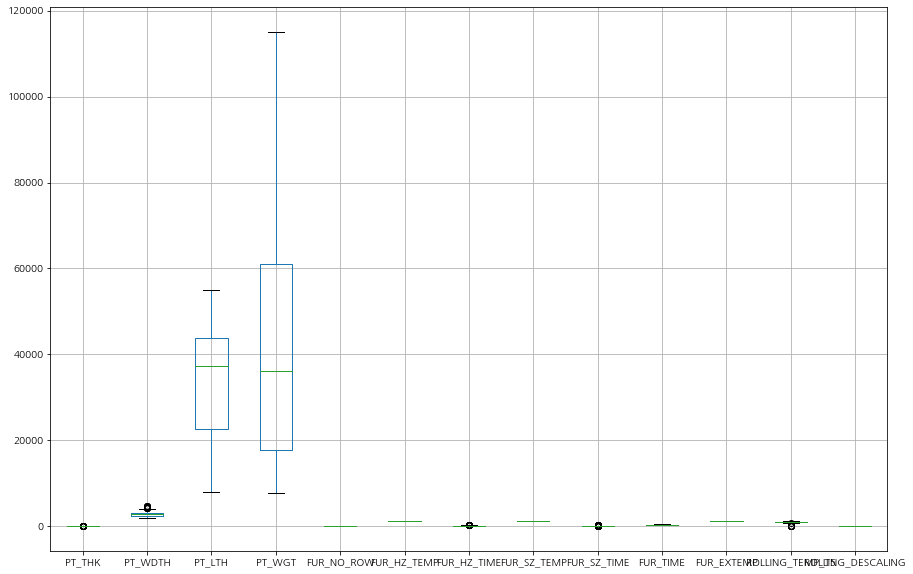

In [12]:
df_raw.boxplot(figsize = (15,10))

### object형태, 범주형데이터,목표변수를 제외한 설명변수들의 이상치들을 확인

{'whiskers': [<matplotlib.lines.Line2D at 0x7fac996d7eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac996655f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fac996d7ac8>,
 'medians': [<matplotlib.lines.Line2D at 0x7fac99665c88>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac99665fd0>,
 'means': []}

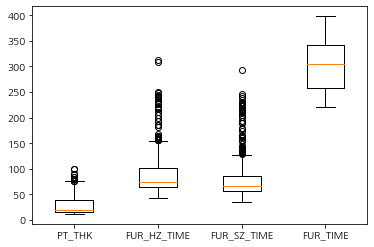

In [105]:
fig, ax = plt.subplots()

ax.boxplot([df_raw['PT_THK'], df_raw['FUR_HZ_TIME'],df_raw['FUR_SZ_TIME'],df_raw['FUR_TIME']],
           labels=['PT_THK','FUR_HZ_TIME','FUR_SZ_TIME','FUR_TIME'])

In [106]:
df_raw[df_raw['FUR_SZ_TIME']>250]

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
524,양품,LR-A,C0,13.06,3405,54170,56730,2호기,2,1141,59,1130,294,342,1130,875,적용,10,1조


In [107]:
df_raw[df_raw['FUR_HZ_TIME']>300]

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
548,양품,LR-A,C0,17.10,2804,51488,58140,2호기,1,1142,308,1147,69,342,1147,957,적용,10,1조
549,양품,NV-A,C0,18.11,3122,47067,41780,3호기,1,1138,312,1148,62,342,1148,957,적용,10,2조


#### 분석 : FUR_SZ_TIME과 FUR_HZ_TIME에서 총 3개의 이상치를 확인하였다. 하지만 이상치라고 하기에는 근처의 값들과 차이가 많이 나지 않았고 720개중 3개를 제거하기에는 위험성이 있다는 판단하에 건드리지 않았다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fac9960c390>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac9960ca90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fac99600f60>,
 'medians': [<matplotlib.lines.Line2D at 0x7fac9960ceb8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac996194a8>,
 'means': []}

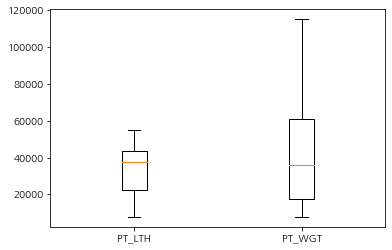

In [108]:
fig, ax = plt.subplots()

ax.boxplot([df_raw['PT_LTH'], df_raw['PT_WGT']],
           labels=['PT_LTH','PT_WGT'])

#### 분석 : PT_LTH와PT_WGT의 이상치는 발견하지 못하였다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fac9957c9b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac9957ce48>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fac9957c5c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fac99588780>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac99588ac8>,
 'means': []}

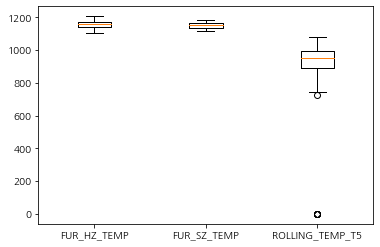

In [109]:
fig, ax = plt.subplots()

ax.boxplot([ df_raw['FUR_HZ_TEMP'],df_raw['FUR_SZ_TEMP'],df_raw['ROLLING_TEMP_T5']],
           labels=['FUR_HZ_TEMP','FUR_SZ_TEMP','ROLLING_TEMP_T5'])

In [110]:
df_raw[df_raw['ROLLING_TEMP_T5']<200]

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,양품,GL-E36-TM,T8,55.51,3765,11398,37400,3호기,2,1132,95,1128,80,341,1128,0,적용,6,1조
184,양품,JS-SM490YB,C0,16.09,2221,43596,61150,3호기,1,1169,64,1164,61,308,1164,0,적용,10,3조
185,양품,JS-SM490YB,C0,16.09,2221,43596,61150,3호기,2,1163,57,1166,67,303,1166,0,적용,10,4조
494,양품,PILAC-BT33,T5,80.82,2085,12919,17090,2호기,1,1133,89,1122,59,378,1122,0,적용,6,2조
495,양품,PILAC-BT33,T5,80.82,2085,13176,17430,1호기,2,1130,92,1124,61,362,1124,0,적용,6,3조
496,양품,NV-D32-TM,T0,40.35,2497,23592,37320,3호기,1,1119,109,1117,76,383,1117,0,적용,6,3조


Text(0, 0.5, '빈도')

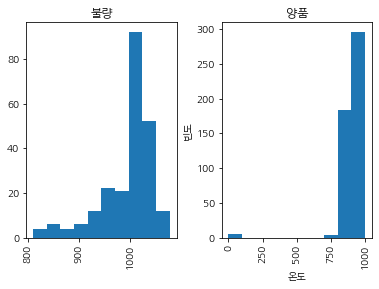

In [111]:
df_raw.hist(column="ROLLING_TEMP_T5",by = "SCALE") #스케일 통일해야 함
plt.xlabel("온도");plt.ylabel('빈도')

In [112]:
df_raw['ROLLING_TEMP_T5'].mean()

933.9208333333333

In [113]:
df_raw.groupby('SCALE').mean()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,,,,,,,,,,,,,
불량,25.790952,2652.012987,36343.385281,49353.593074,1.480519,1162.852814,91.601732,1159.242424,66.086580,297.316017,1159.242424,994.294372,8.303030
양품,30.910321,2880.402863,33368.981595,37763.190184,1.505112,1151.789366,87.075665,1145.143149,84.809816,302.098160,1145.143149,905.400818,8.327198


In [114]:
df_raw.groupby('SCALE').median()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,,,,,,,,,,,,,
불량,20.13,2516,37440,42720,1,1163,77,1161,62,299,1161,1008,8
양품,20.13,2875,37198,32840,2,1151,74,1147,71,308,1147,925,8


In [115]:
df_raw['ROLLING_TEMP_T5'] = df_raw['ROLLING_TEMP_T5'].replace(0,905.400818)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fac993ebb70>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac993ebeb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fac993eb780>],
 'medians': [<matplotlib.lines.Line2D at 0x7fac993f8940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fac993f8c88>],
 'means': []}

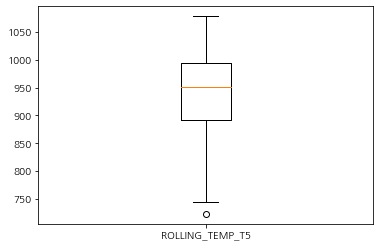

In [116]:
plt.boxplot(df_raw['ROLLING_TEMP_T5'],labels = ['ROLLING_TEMP_T5'])

#### 분석 : ROLLING_TEMP_T5의 평균이 933일때경우 이상치들이 모두 0이였다. 다른 값들과 차이가 많이 나기때문에 평균으로 대체해야 한다고 판단하였다. 이때 ROLLING_TEMP_T5 이상치들의 scale이 모두  1이였으므로 scale이1일때 ROLLING_TEMP_T5의 평균으로 대체해주었다.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fac993cdb38>,
 'caps': [<matplotlib.lines.Line2D at 0x7fac993cdfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fac993cd748>],
 'medians': [<matplotlib.lines.Line2D at 0x7fac9935b908>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fac9935bc50>],
 'means': []}

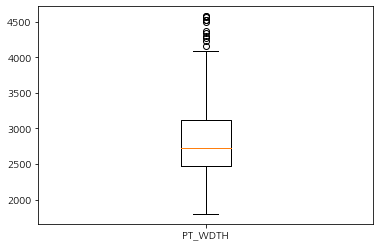

In [117]:
plt.boxplot(df_raw['PT_WDTH'],labels = ['PT_WDTH'])

#### 분석 : PT_WDTH의 경우에는 따로 이상치를 확인하지 못하였다.

### 탐색적 분석

In [24]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934.0,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937.0,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889.0,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885.0,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873.0,적용,8,1조


### FUR_SZ_TEMP와 FUR_EXTEMP의 값은 모두 같음 따라서 상관성,중요도도 같다고 볼 수 있음.

In [25]:
len(df_raw[df_raw['FUR_SZ_TEMP']==df_raw['FUR_EXTEMP']])/len(df_raw)

1.0

### spec와 steel kind를 제외하고 모든 object를 int로 바꿈

In [26]:
df_raw['SCALE'] = np.where(df_raw['SCALE']=='양품',0,1)
df_raw['HSB'] = np.where(df_raw['HSB']=='미적용',0,1)
df_raw['FUR_NO'] = df_raw['FUR_NO'].str[0]
df_raw['WORK_GR'] = df_raw['WORK_GR'].str[0]
df_raw['STEEL_KIND'] = df_raw['STEEL_KIND'].str[0]

In [27]:
df_raw['FUR_NO'] = df_raw['FUR_NO'].astype(int)
df_raw['WORK_GR'] = df_raw['WORK_GR'].astype(int)
df_raw['STEEL_KIND'] = np.where(df_raw['STEEL_KIND']=='T',0,1)

In [28]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 19 columns):
SCALE                720 non-null int64
SPEC                 720 non-null object
STEEL_KIND           720 non-null int64
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null int64
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null float64
HSB                  720 non-null int64
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null int64
dtypes: float64(2), int64(16), object(1)
memory usage: 107.0+ KB


In [29]:
df_raw.corr()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
SCALE,1.000000,0.328117,-0.124858,-0.206021,0.100475,0.218741,0.050995,-0.022960,0.247670,0.056139,0.374809,-0.240137,-0.049214,0.374809,0.553720,-0.318880,-0.006955,-0.005268
STEEL_KIND,0.328117,1.000000,-0.784479,0.198824,0.779233,0.453767,0.003253,0.005627,0.478078,-0.112423,0.809853,-0.212728,-0.348380,0.809853,0.746528,0.006158,0.725816,0.017869
PT_THK,-0.124858,-0.784479,1.000000,-0.313151,-0.862618,-0.397391,-0.005089,-0.002530,-0.523926,0.160110,-0.694770,0.113171,0.413009,-0.694770,-0.500438,-0.017628,-0.836631,-0.021797
PT_WDTH,-0.206021,0.198824,-0.313151,1.000000,0.119726,0.031009,0.030380,0.006727,0.180024,-0.119175,0.227296,0.022627,-0.393200,0.227296,-0.108806,-0.041914,0.337540,-0.023479
PT_LTH,0.100475,0.779233,-0.862618,0.119726,1.000000,0.451815,0.048381,-0.021185,0.473111,-0.077392,0.645402,-0.070225,-0.251950,0.645402,0.434093,-0.018222,0.809280,0.015471
PT_WGT,0.218741,0.453767,-0.397391,0.031009,0.451815,1.000000,0.064470,-0.022241,0.153331,0.010491,0.359513,-0.190922,-0.057776,0.359513,0.419218,0.022630,0.238986,0.059622
FUR_NO,0.050995,0.003253,-0.005089,0.030380,0.048381,0.064470,1.000000,-0.005059,0.038953,0.030794,0.054853,-0.046472,-0.025261,0.054853,0.017606,-0.039430,-0.037591,-0.046673
FUR_NO_ROW,-0.022960,0.005627,-0.002530,0.006727,-0.021185,-0.022241,-0.005059,1.000000,0.004753,-0.015791,0.009228,0.049045,0.016053,0.009228,-0.006548,-0.021142,0.018219,0.073994
FUR_HZ_TEMP,0.247670,0.478078,-0.523926,0.180024,0.473111,0.153331,0.038953,0.004753,1.000000,-0.114395,0.772907,-0.222141,-0.348223,0.772907,0.356989,-0.035614,0.470899,-0.027298
FUR_HZ_TIME,0.056139,-0.112423,0.160110,-0.119175,-0.077392,0.010491,0.030794,-0.015791,-0.114395,1.000000,-0.203401,0.177922,0.473137,-0.203401,0.006259,0.008544,-0.137742,-0.007689


#### 분석 : 위의 상관관계에서 ROLLING TEMP T5, FUR SZ TEMP=FUR EXTEMP,STEEL_KIND,HSB, FUR SZ TIME순으로 상관이 큰것으로 보인다.

In [30]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB/EH32-TM,0,32.25,3707,15109,14180,1,1,1144,116,1133,59,282,1133,934.0,1,8,2
1,0,AB/EH32-TM,0,32.25,3707,15109,14180,1,2,1144,122,1135,53,283,1135,937.0,1,8,2
2,0,NV-E36-TM,0,33.27,3619,19181,18130,2,1,1129,116,1121,55,282,1121,889.0,1,8,3
3,0,NV-E36-TM,0,33.27,3619,19181,18130,2,2,1152,125,1127,68,316,1127,885.0,1,8,3
4,0,BV-EH36-TM,0,38.33,3098,13334,12430,3,1,1140,134,1128,48,314,1128,873.0,1,8,1


### 범주형 데이터들과 SCALE과의 관계 보기

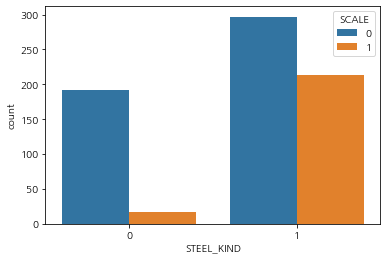

In [31]:
sns.countplot("STEEL_KIND",hue="SCALE", data = df_raw)

In [32]:
len(df_raw[(df_raw['STEEL_KIND']==0)&(df_raw['SCALE']==1)])/len(df_raw[df_raw['SCALE']==1])

0.0735930735930736

#### 분석 : Steel Kind가 T일때 불량품은 7.3%으로 확인할 수 있었다. 즉 Steel Kind가  T종류일때 불량률이 줄어드는 것을 알 수 있었다.         0-T 1-C steel kind의 경우 t와 c로 나누었다. 파란색은 양품,주황색은 불량

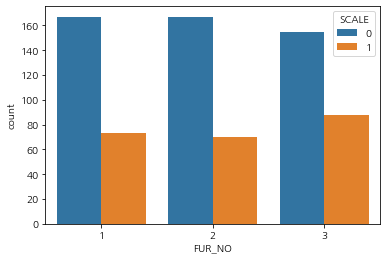

In [33]:
sns.countplot("FUR_NO",hue="SCALE", data = df_raw)

#### 분석 : 가열로 호기별 양품과 불량의 차이를 보는 그래프. 호기별 양품과 불량모두 차이가 크게 없으므로 가열로 호기는 영향을 주지 않는 것으로 판단하였다.

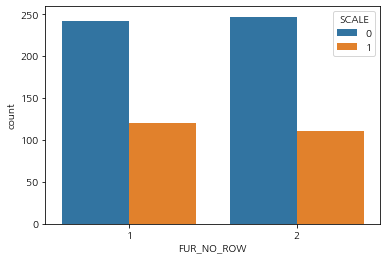

In [34]:
sns.countplot("FUR_NO_ROW",hue="SCALE", data = df_raw)

### 분석 : 가열로 작업순번별 양품과 불량의 차이는 없으므로 영향을 주지 않는다.

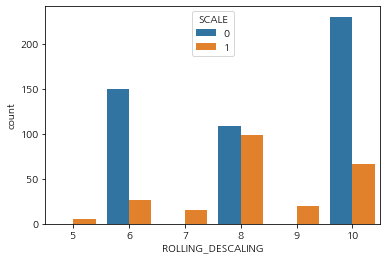

In [35]:
sns.countplot("ROLLING_DESCALING",hue="SCALE", data = df_raw)

In [36]:
len(df_raw[(df_raw['ROLLING_DESCALING']==8)&(df_raw['SCALE']==0)])

109

In [37]:
len(df_raw[(df_raw['ROLLING_DESCALING']==8)&(df_raw['SCALE']==1)])

99

#### 분석 : 압연중 Descaling의 횟수가 6과 10일때는 양품의 개수가 월등히 많은것을 볼 수 있다. 하지만 8번 했을 때는 크게 차이가 나지않는다.실제로 descaling횟수가 8번일때 양품의 개수는 109개,불량의 개수는 99개로 10밖에 차이나지 않는다. 그래프를 통해서도 불량은 descaling이 8일대 가장 많이 나타났다.

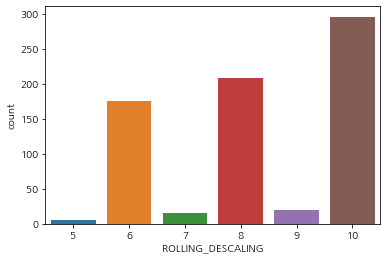

In [38]:
sns.countplot("ROLLING_DESCALING", data = df_raw)

In [39]:
len(df_raw[(df_raw['ROLLING_DESCALING']==6)&(df_raw['SCALE']==1)])/len(df_raw[df_raw['ROLLING_DESCALING']==6])

0.14772727272727273

In [40]:
len(df_raw[(df_raw['ROLLING_DESCALING']==8)&(df_raw['SCALE']==1)])/len(df_raw[df_raw['ROLLING_DESCALING']==8])

0.47596153846153844

In [41]:
len(df_raw[(df_raw['ROLLING_DESCALING']==10)&(df_raw['SCALE']==1)])/len(df_raw[df_raw['ROLLING_DESCALING']==10])

0.22297297297297297

#### 분석 : descaling한 횟수가 8일때가 가장 많아서 불량이 많이 나타났다고 의문점이 들 수도 있다. 위의 그래프에서는 descaling의 횟수가 6,8,10인 경우가 압도적으로 많았다. 각각의 descaling횟수에서의 불량률을 구하면 다음과같다. 각각 14.7%, 47.5%, 22.2%로 8일때 불량률이 거의 절반을 차지하는 것을 볼 수 있다.

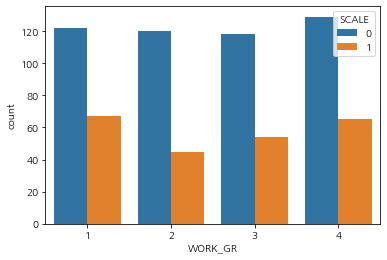

In [42]:
sns.countplot("WORK_GR",hue="SCALE", data = df_raw)

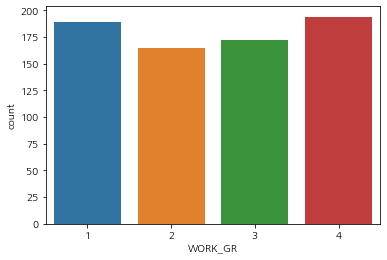

In [43]:
sns.countplot("WORK_GR", data = df_raw)

#### 분석 : 작업조 별로 살펴본결과 양품과 불량에는 큰 차이를 주지 않는 것을 보여준다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac9ad1c048>,
      dtype=object)

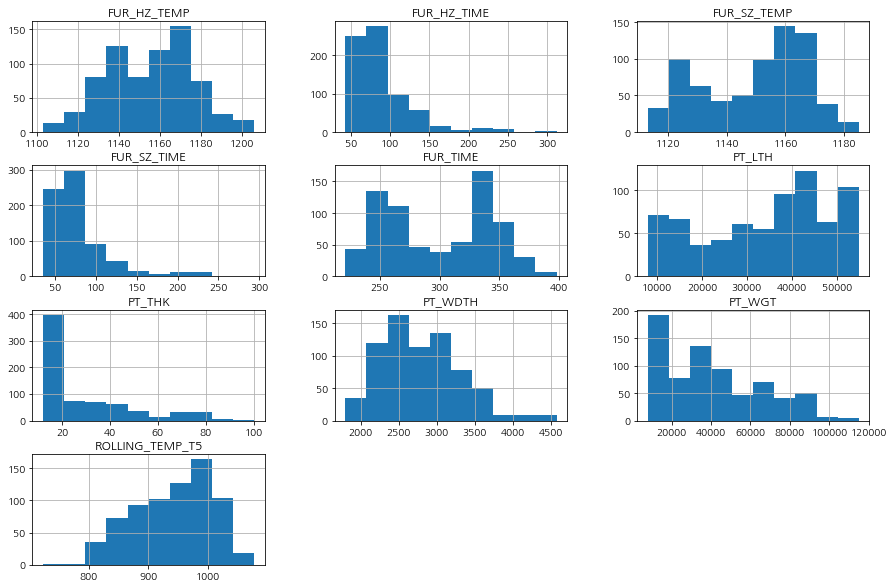

In [44]:
df_raw.hist(column=['PT_THK','PT_WDTH','PT_LTH','PT_WGT','FUR_HZ_TEMP','FUR_HZ_TIME','FUR_SZ_TEMP','FUR_SZ_TIME','FUR_TIME','ROLLING_TEMP_T5'],figsize = (15,10))

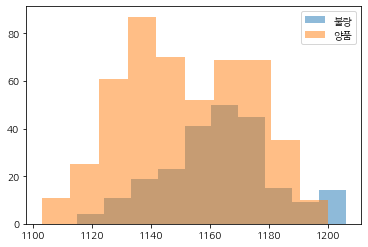

In [45]:
plt.hist(df_raw[df_raw['SCALE']==1]['FUR_HZ_TEMP'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['FUR_HZ_TEMP'],label = '양품',alpha = 0.5)
plt.legend()

In [46]:
len(df_raw[(df_raw['SCALE']==1)&(df_raw['FUR_HZ_TEMP']>1150)&(df_raw['FUR_HZ_TEMP']<1180)])/len(df_raw[df_raw['SCALE']==1])

0.6190476190476191

In [47]:
len(df_raw[(df_raw['SCALE']==1)&(df_raw['FUR_HZ_TEMP']>1150)&(df_raw['FUR_HZ_TEMP']<1180)])

143

#### 분석 : 가열대의 온도가 1150과 1180사이일때 전체 불량중 61.9%의 불량률을 가진다. 따라서 가열대의 온도는 1150이하일때 불량보다 양품일 확률이 커진다고 볼수 있다.

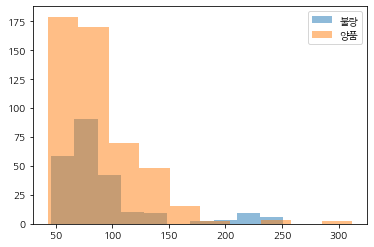

In [48]:
plt.hist(df_raw[df_raw['SCALE']==1]['FUR_HZ_TIME'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['FUR_HZ_TIME'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 : 양품과 불량의 비율이 비슷하므로 가열대 시간은 크게 영향을 주지 않는다고 볼 수 있다.

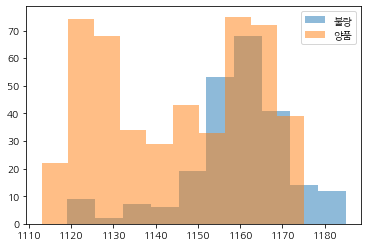

In [49]:
plt.hist(df_raw[df_raw['SCALE']==1]['FUR_SZ_TEMP'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['FUR_SZ_TEMP'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 : 균열대의 온도가 1150이상이 될때 불량의 비율이 급증하는 것을 볼 수 있다. 

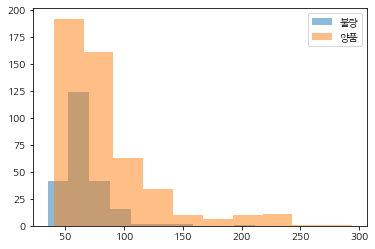

In [50]:
plt.hist(df_raw[df_raw['SCALE']==1]['FUR_SZ_TIME'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['FUR_SZ_TIME'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 : 양품과 불량의 비율이 비슷하게 분포하므로 균열대의 시간이 크게 영향을 주었다고 볼 수 없다.

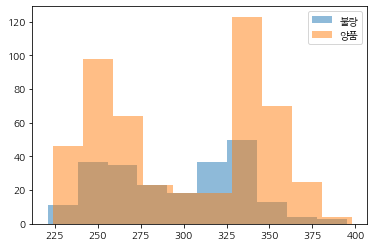

In [51]:
plt.hist(df_raw[df_raw['SCALE']==1]['FUR_TIME'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['FUR_TIME'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 :양품과 불량의 비율이 비슷함 가열로시간은 크게 영향을 주지않음

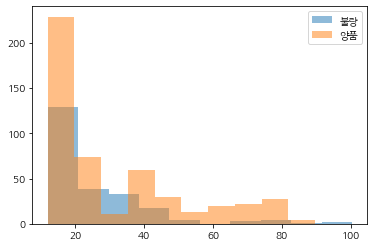

In [52]:
plt.hist(df_raw[df_raw['SCALE']==1]['PT_THK'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['PT_THK'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 : plate의 두께는 양품과 불량에 크게 영향을 주지 않는다.

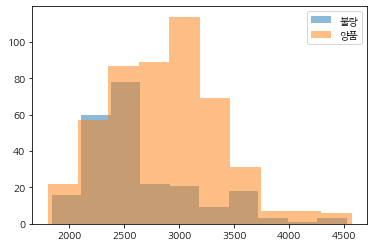

In [53]:
plt.hist(df_raw[df_raw['SCALE']==1]['PT_WDTH'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['PT_WDTH'],label = '양품',alpha = 0.5)
plt.legend()

In [54]:
len(df_raw[(df_raw['PT_WDTH']<2500)&(df_raw['SCALE']==1)])/len(df_raw[df_raw['SCALE']==1])

0.45454545454545453

#### 분석 :  plate의 폭이 2500일때 전체 불량중 45.4%의 불량률을 기록하였다. 2500이상일때 불량보다는 양품이 나올 확률이 높다고 볼수있다.

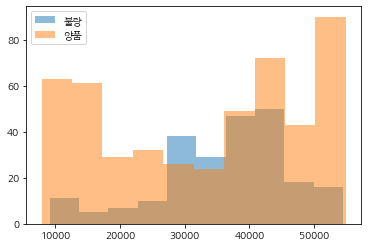

In [55]:
plt.hist(df_raw[df_raw['SCALE']==1]['PT_LTH'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['PT_LTH'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 : plate의 길이가 30000에서 45000사이일때 불량의 수가 많아지는 것을 볼수 있다.

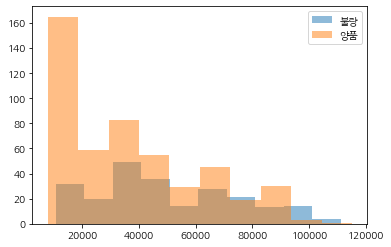

In [56]:
plt.hist(df_raw[df_raw['SCALE']==1]['PT_WGT'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['PT_WGT'],label = '양품',alpha = 0.5)
plt.legend()

#### 분석 : plate의 중량은 양품과 불량에 크게 영향을 주지 않는것으로 판단

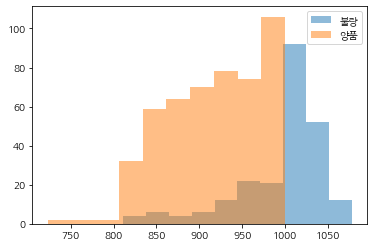

In [57]:
plt.hist(df_raw[df_raw['SCALE']==1]['ROLLING_TEMP_T5'],label = '불량',alpha = 0.5)
plt.hist(df_raw[df_raw['SCALE']==0]['ROLLING_TEMP_T5'],label = '양품',alpha = 0.5)
plt.legend()

### SPEC설명변수의 종류가 많으므로 관계가 깊은 것끼리 묶어주기

In [61]:
len(df_raw['SPEC'].unique())

66

In [63]:
df_raw['SPEC_TYPE'] = df_raw['SPEC'].str[:2]
df_raw['SPEC_TYPE'].value_counts()

JS    146
LR    105
NV    105
BV     86
GL     56
PI     40
AB     37
KR     31
CO     28
KS     28
SA     21
NK     20
A2      6
V4      4
AP      2
A5      2
A7      1
A1      1
CC      1
Name: SPEC_TYPE, dtype: int64

In [64]:
df_raw = df_raw.drop('SPEC',axis = 1)
df_raw.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC_TYPE
0,0,0,32.25,3707,15109,14180,1,1,1144,116,1133,59,282,1133,934.0,1,8,2,AB
1,0,0,32.25,3707,15109,14180,1,2,1144,122,1135,53,283,1135,937.0,1,8,2,AB
2,0,0,33.27,3619,19181,18130,2,1,1129,116,1121,55,282,1121,889.0,1,8,3,NV
3,0,0,33.27,3619,19181,18130,2,2,1152,125,1127,68,316,1127,885.0,1,8,3,NV
4,0,0,38.33,3098,13334,12430,3,1,1140,134,1128,48,314,1128,873.0,1,8,1,BV


In [66]:
len(df_raw['SPEC_TYPE'].unique())

19

#### 분석 : 66개의 spec 종류를 19개로 줄였다.

### 관계성 높은 설명변수 확인하기

### 3. 영향인자 찾아보기

### Decision Tree

### 더미변수 만들기 전 object데이터들 정리하기

In [68]:
df_raw.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC_TYPE
0,0,0,32.25,3707,15109,14180,1,1,1144,116,1133,59,282,1133,934.0,1,8,2,AB
1,0,0,32.25,3707,15109,14180,1,2,1144,122,1135,53,283,1135,937.0,1,8,2,AB
2,0,0,33.27,3619,19181,18130,2,1,1129,116,1121,55,282,1121,889.0,1,8,3,NV
3,0,0,33.27,3619,19181,18130,2,2,1152,125,1127,68,316,1127,885.0,1,8,3,NV
4,0,0,38.33,3098,13334,12430,3,1,1140,134,1128,48,314,1128,873.0,1,8,1,BV


In [69]:
df_raw['FUR_NO'].unique()

array([1, 2, 3])

In [13]:
df_raw['SCALE'] = np.where(df_raw['SCALE']=='양품',0,1)
df_raw['HSB'] = np.where(df_raw['HSB']=='미적용',0,1)

In [14]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,1,8,2조
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,1,8,2조
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,1,8,3조
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,1,8,3조
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,1,8,1조


In [15]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 19 columns):
SCALE                720 non-null int64
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null int64
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(14), object(4)
memory usage: 107.0+ KB


In [16]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 19 columns):
SCALE                720 non-null int64
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null int64
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(14), object(4)
memory usage: 107.0+ KB


#### 더미 변수를 만들어 주기전에 object로 이루어진 설명변수를 줄여주는 작업을 하였다. FUR_NO와WORK_GR을 int로 변경

### 더미변수 만들기

In [17]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T5,STEEL_KIND_T7,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,0,0,1,0,0,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,0,0,1,0,0,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,0,0,1,0,1,0,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,0,0,1,0,1,0,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,0,0,1,0,0,1,1,0,0,0


In [18]:
df_raw_x = df_raw_dummy.drop('SCALE',axis = 1,inplace = False)
df_raw_y = df_raw_dummy['SCALE']

### 데이터 분할

In [19]:
df_raw_x.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,STEEL_KIND_T5,STEEL_KIND_T7,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,32.25,3707,15109,14180,1,1144,116,1133,59,282,...,0,0,0,1,0,0,0,1,0,0
1,32.25,3707,15109,14180,2,1144,122,1135,53,283,...,0,0,0,1,0,0,0,1,0,0
2,33.27,3619,19181,18130,1,1129,116,1121,55,282,...,0,0,1,0,1,0,0,0,1,0
3,33.27,3619,19181,18130,2,1152,125,1127,68,316,...,0,0,1,0,1,0,0,0,1,0
4,38.33,3098,13334,12430,1,1140,134,1128,48,314,...,0,0,1,0,0,1,1,0,0,0


In [20]:
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size = 0.3,random_state = 1234)

### 모델생성

In [21]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print('train score :',tree_uncustomized.score(df_train_x,df_train_y))
print('test score :',tree_uncustomized.score(df_test_x,df_test_y))

train score : 1.0
test score : 0.9907407407407407


#### 분석 : train score가 1이므로 과적합으로 볼 수 있다.

### Parameter조정

### Depth조정

In [22]:
train_accuracy = [];test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth=v_max_depth,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

In [23]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.887,0.898
1,2,0.929,0.944
2,3,0.958,0.972
3,4,0.966,0.977
4,5,0.968,0.977
5,6,0.972,0.977
6,7,0.972,0.977
7,8,0.978,0.977
8,9,0.978,0.977
9,10,0.990,0.995


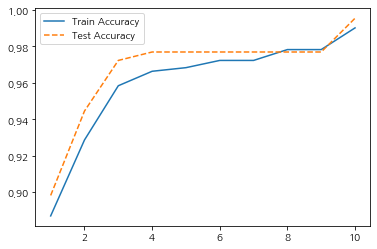

In [24]:
plt.plot(para_depth,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train과 test의 정확도가 둘다 높으면서 차이가 적은 8을 선택

### min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [25]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*10 for n_split in range(1,11)]

for v_para_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_para_split,max_depth=8,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

In [26]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.97,0.977
1,20,0.97,0.977
2,30,0.97,0.977
3,40,0.97,0.977
4,50,0.97,0.977
5,60,0.97,0.977
6,70,0.97,0.977
7,80,0.97,0.977
8,90,0.97,0.977
9,100,0.97,0.977


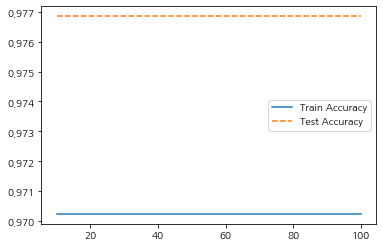

In [27]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

### 10이전의 값 보기

In [28]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*2 for n_split in range(1,11)]

for v_para_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_para_split,max_depth=8,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

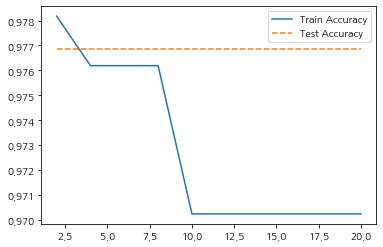

In [29]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [30]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,2,0.978,0.977
1,4,0.976,0.977
2,6,0.976,0.977
3,8,0.976,0.977
4,10,0.970,0.977
5,12,0.970,0.977
6,14,0.970,0.977
7,16,0.970,0.977
8,18,0.970,0.977
9,20,0.970,0.977


#### 분석 : test와 train이 일치하는 3을 선택

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [31]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_para_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_para_leaf,min_samples_split = 3,max_depth=8,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy
df_accuracy_leaf['Train-Test'] = df_accuracy_leaf['TrainAccuracy']-df_accuracy_leaf['TestAccuracy']

In [32]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy,Train-Test
0,2,0.974,0.977,-0.003
1,4,0.978,0.977,0.001
2,6,0.980,0.991,-0.011
3,8,0.980,0.991,-0.011
4,10,0.980,0.991,-0.011
5,12,0.978,0.991,-0.013
6,14,0.968,0.972,-0.004
7,16,0.964,0.968,-0.003
8,18,0.954,0.963,-0.009
9,20,0.954,0.963,-0.009


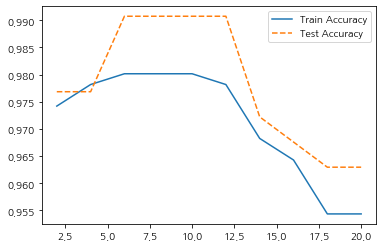

In [33]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

### 4와 7사이를 확대

In [34]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf for n_leaf in range(4,8)]

for v_para_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_para_leaf,min_samples_split = 3,max_depth=8,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy
df_accuracy_leaf['Train-Test'] = df_accuracy_leaf['TrainAccuracy']-df_accuracy_leaf['TestAccuracy']

In [35]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy,Train-Test
0,4,0.978,0.977,0.001
1,5,0.980,0.991,-0.011
2,6,0.980,0.991,-0.011
3,7,0.980,0.991,-0.011


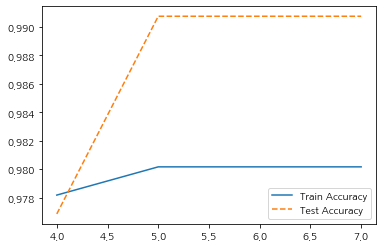

In [36]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train과test가 모두 높으면서 둘 사이의 차이가 가장 적은 4를 선택

### 최종 모델

In [37]:
tree_final = DecisionTreeClassifier(max_depth=8,min_samples_split=3,min_samples_leaf=4,random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [38]:
v_feature_name = df_train_x.columns

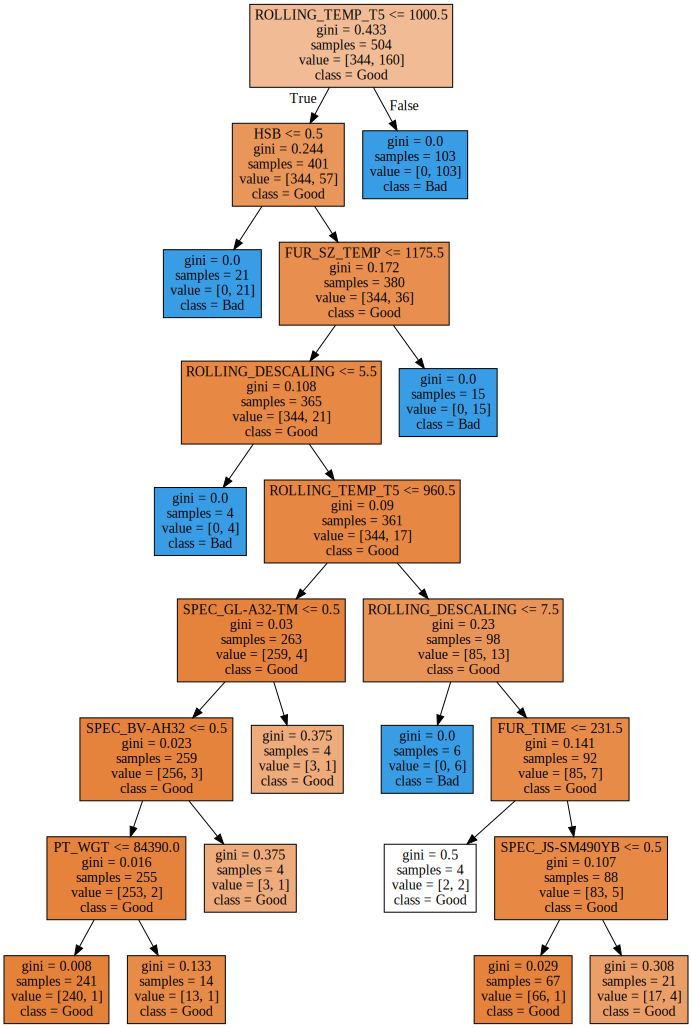

In [39]:
export_graphviz(tree_final,out_file = 'tree_low.dot',class_names = ['Good','Bad'],
               feature_names = v_feature_name,impurity=True,filled = True)

with open('tree_low.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 최종 모델평가

In [40]:
y_pred = tree_final.predict(df_test_x)
print('test score:',tree_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

test score: 0.9768518518518519
[[144   1]
 [  4  67]]


### 결론도출

Text(0, 0.5, '설명변수')

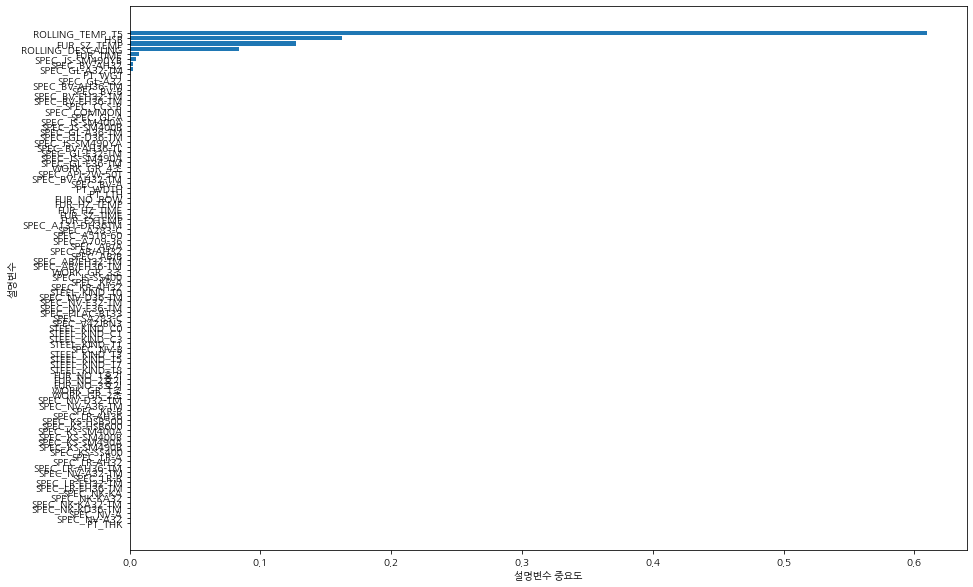

In [41]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance',ascending = True,inplace = True)
coordinates = range(len(df_importance))

plt.figure(figsize=(15,10))
plt.barh(y=coordinates,width = df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

#### 분석 : 목표변수에 영향력이 큰 설명변수를 순서대로 나열하면 다음과 같다. ROLLING_TEMP_T5, HSB, FUR_SZ_TEMP, ROLLING_DESCALING, FUR_TIME, PT_LTH

### 랜덤포레스트

### 위의 과정에서 데이터 분할까지 하였으므로 모델부터 생성한다.

### 모델생성

In [42]:
tree_uncustomized = RandomForestClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print(tree_uncustomized.score(df_train_x,df_train_y))
print(tree_uncustomized.score(df_test_x,df_test_y))

0.9920634920634921
0.9166666666666666


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### 분석 : train의 score가 너무 크므로 과적합으로 보인다 따라서 parameter조정이 필요하다

### n_estimators: 트리 수 변경에 따른 모델 성능

In [43]:
train_accuracy = [];test_accuracy = []
para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

In [44]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.992,0.917
1,20,0.998,0.921
2,30,1.000,0.935
3,40,1.000,0.935
4,50,1.000,0.940
5,60,1.000,0.940
6,70,1.000,0.940
7,80,1.000,0.940
8,90,1.000,0.944
9,100,1.000,0.935


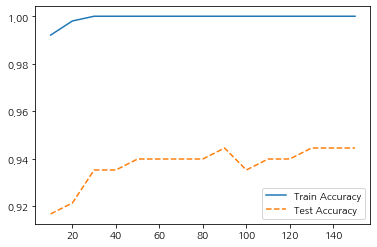

In [45]:
plt.plot(para_n_tree,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

### 10이전의 값을 살펴본다

In [46]:
train_accuracy = [];test_accuracy = []
para_n_tree = [n_tree for n_tree in range(1,17)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy
df_accuracy_n['Train-Test'] = df_accuracy_n['TrainAccuracy']-df_accuracy_n['TestAccuracy']

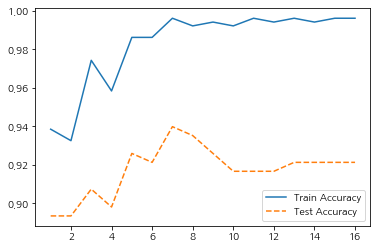

In [47]:
plt.plot(para_n_tree,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [48]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy,Train-Test
0,1,0.938,0.894,0.045
1,2,0.933,0.894,0.039
2,3,0.974,0.907,0.067
3,4,0.958,0.898,0.060
4,5,0.986,0.926,0.060
5,6,0.986,0.921,0.065
6,7,0.996,0.940,0.056
7,8,0.992,0.935,0.057
8,9,0.994,0.926,0.068
9,10,0.992,0.917,0.075


#### 분석 : 20이후부터는 train의 정확도가 1로 과적합 경향을 보이므로20 이전의 값을 선택한다. 그중에서 train과 test의 차이가 가장 적은 9을 선택하였다.

### Depth조정

In [49]:
train_accuracy = [];test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(n_estimators = 9,max_depth=v_max_depth,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy
df_accuracy_depth['Train-Test'] = df_accuracy_depth['TrainAccuracy']-df_accuracy_depth['TestAccuracy']

In [50]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy,Train-Test
0,1,0.683,0.671,0.011
1,2,0.887,0.889,-0.002
2,3,0.901,0.907,-0.007
3,4,0.925,0.894,0.031
4,5,0.921,0.907,0.013
5,6,0.942,0.903,0.040
6,7,0.966,0.944,0.022
7,8,0.982,0.940,0.042
8,9,0.988,0.944,0.044
9,10,0.988,0.949,0.039


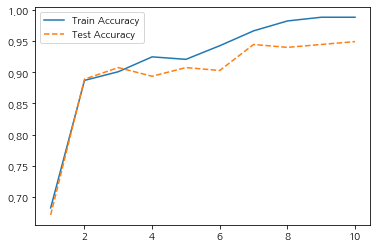

In [51]:
plt.plot(para_depth,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train의 값이 1인것은 과적합이므로 제외한다. 그중에서 train의 정확도가 0.9를 넘으면서 test와의 차이가 크게 나지 않는 4를 선택하였다.

### min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [52]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*10 for n_split in range(1,11)]

for v_para_split in para_split:
    rf = RandomForestClassifier(n_estimators = 9,min_samples_split = v_para_split,max_depth=4,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy
df_accuracy_split['Train-Test'] = df_accuracy_split['TrainAccuracy']-df_accuracy_split['TestAccuracy']

In [53]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy,Train-Test
0,10,0.921,0.921,-0.001
1,20,0.921,0.921,-0.001
2,30,0.921,0.921,-0.001
3,40,0.915,0.917,-0.002
4,50,0.909,0.907,0.001
5,60,0.911,0.926,-0.015
6,70,0.921,0.931,-0.010
7,80,0.919,0.926,-0.007
8,90,0.923,0.926,-0.003
9,100,0.925,0.926,-0.001


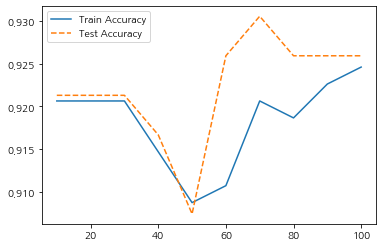

In [54]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train과 test가 높은 정확도를 나타내면서 둘 사이의 차이가 적은 80을 선택하였다.

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [55]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_para_leaf in para_leaf:
    rf = RandomForestClassifier(n_estimators = 9,min_samples_leaf = v_para_leaf,min_samples_split = 80,max_depth=4,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

In [56]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy
0,2,0.921,0.926
1,4,0.915,0.926
2,6,0.919,0.921
3,8,0.915,0.917
4,10,0.907,0.907
5,12,0.887,0.894
6,14,0.885,0.889
7,16,0.887,0.889
8,18,0.885,0.875
9,20,0.863,0.866


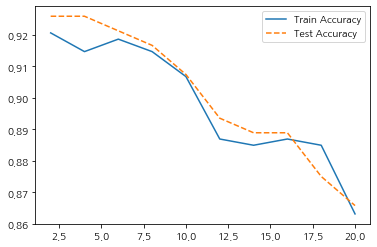

In [57]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

### 5이전의 값을 확대

In [58]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf for n_leaf in range(1,6)]

for v_para_leaf in para_leaf:
    rf = RandomForestClassifier(n_estimators = 8,min_samples_leaf = v_para_leaf,min_samples_split = 90,max_depth=4,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

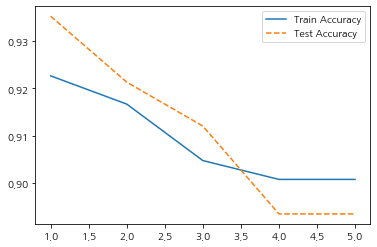

In [59]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [60]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy
0,1,0.923,0.935
1,2,0.917,0.921
2,3,0.905,0.912
3,4,0.901,0.894
4,5,0.901,0.894


#### 분석 : train과 test가 모두 2에서 급격하게 증가하였다가 감소하므로 2를 선택하였다.

### 최종 모델

In [61]:
rf_final = RandomForestClassifier(n_estimators = 9,max_depth=4,min_samples_split=80,min_samples_leaf=2,random_state=1234)
rf_final.fit(df_train_x,df_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=80,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [62]:
v_feature_name = df_train_x.columns

In [63]:
y_pred = rf_final.predict(df_test_x)

print(rf_final.score(df_train_x,df_train_y))
print(rf_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

0.9206349206349206
0.9259259259259259
[[145   0]
 [ 16  55]]


Text(0, 0.5, '설명변수')

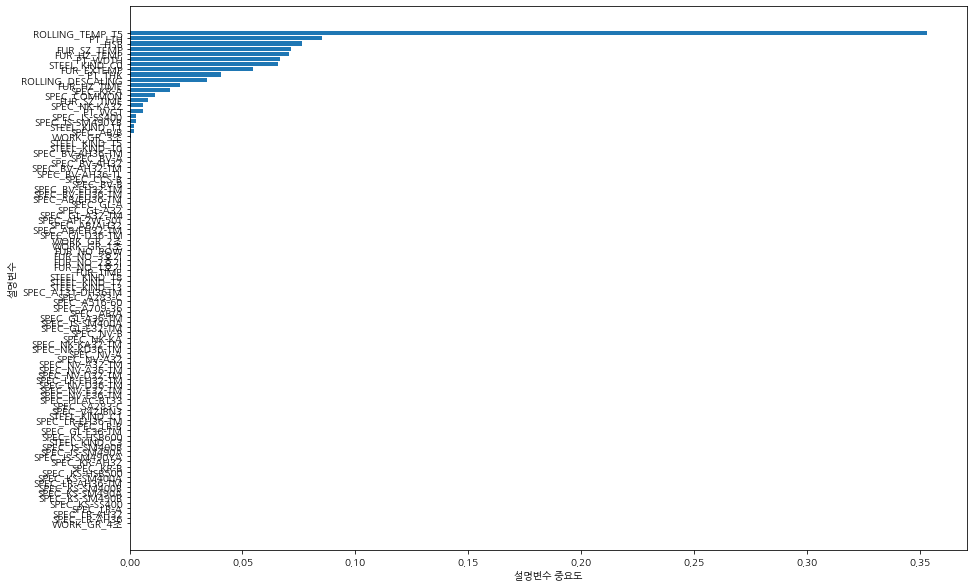

In [64]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

plt.figure(figsize=(15,10))

df_importance.sort_values('Importance',ascending = True,inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width = df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

#### 분석 : 목표변수와 관계가 가장 높은 설명변수를 순서대로 나열하면 다음과 같다. ROLLING_TEMP_T5, STEEL_KIND_C0, PT_WDTH,PT_LTH,FUR_SZ_TEP,ROLLING_DESCALING,FUR_EXTEMP,HSB

### 그래디언트 부스팅

### 모델생성

In [65]:
tree_uncustomized = GradientBoostingClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print('train score :',tree_uncustomized.score(df_train_x,df_train_y))
print('test score :',tree_uncustomized.score(df_test_x,df_test_y))

train score : 1.0
test score : 0.9953703703703703


#### train score와 test score가 모두 1이므로 과적합이다. 따라서 parameter조정이 필요하다

In [66]:
train_accuracy = [];test_accuracy = []
para_lr = [n_tree*0.1 for n_tree in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate=v_learning_rate,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

In [67]:
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,1.0,0.995
1,0.2,1.0,0.995
2,0.3,1.0,1.000
3,0.4,1.0,0.995
4,0.5,1.0,0.986
5,0.6,1.0,0.986
6,0.7,1.0,0.981
7,0.8,1.0,0.986
8,0.9,1.0,0.986


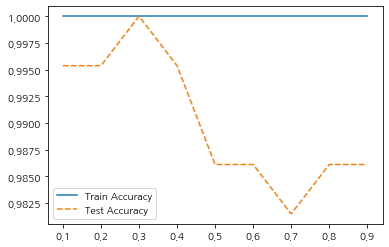

In [68]:
plt.plot(para_lr,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_lr,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### train의 경우 1에서 변화가 없으므로 test를 기준으로 0.4를 선택

### n_estimators: 트리 수 변경에 따른 모델 성능

In [69]:
train_accuracy = [];test_accuracy = []
para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(learning_rate = 0.4,n_estimators=v_n_estimators,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy
df_accuracy_n['train-test'] = df_accuracy_n['TrainAccuracy']-df_accuracy_n['TestAccuracy']

In [70]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy,train-test
0,10,0.990,0.972,0.018
1,20,0.996,0.968,0.028
2,30,1.000,0.977,0.023
3,40,1.000,0.986,0.014
4,50,1.000,0.991,0.009
5,60,1.000,1.000,0.000
6,70,1.000,1.000,0.000
7,80,1.000,0.995,0.005
8,90,1.000,0.995,0.005
9,100,1.000,0.995,0.005


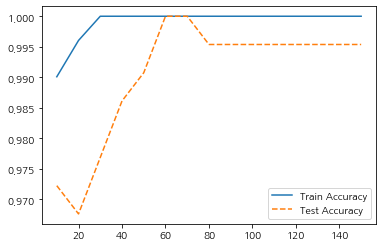

In [71]:
plt.plot(para_n_tree,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train의 정확도가 20 이후로는 1을 유지한다. 10이전의 값들을 살펴본다

In [72]:
train_accuracy = [];test_accuracy = []
para_n_tree = [n_tree*2 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(learning_rate = 0.4,n_estimators=v_n_estimators,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy
df_accuracy_n['train-test'] = df_accuracy_n['TrainAccuracy']-df_accuracy_n['TestAccuracy']

In [73]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy,train-test
0,2,0.958,0.972,-0.014
1,4,0.978,0.977,0.001
2,6,0.982,0.977,0.005
3,8,0.984,0.977,0.007
4,10,0.990,0.972,0.018
5,12,0.990,0.972,0.018
6,14,0.992,0.972,0.020
7,16,0.994,0.968,0.026
8,18,0.996,0.968,0.028
9,20,0.996,0.968,0.028


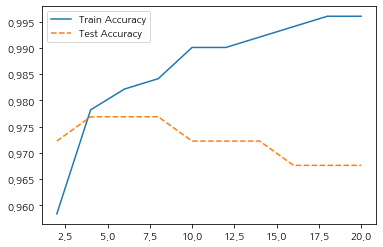

In [74]:
plt.plot(para_n_tree,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train과 test모두 높은 정확도를 보이고 있으므로 둘의 차이가 가장 적은 4를 선택하였다.

### Depth조정

In [75]:
train_accuracy = [];test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(learning_rate = 0.4,n_estimators = 4,max_depth=v_max_depth,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy
df_accuracy_depth['Train-Test'] = df_accuracy_depth['TrainAccuracy']-df_accuracy_depth['TestAccuracy']

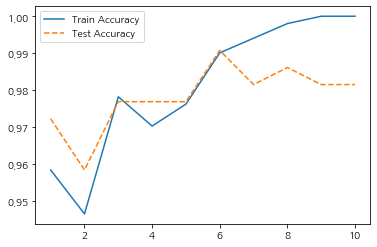

In [76]:
plt.plot(para_depth,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [77]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy,Train-Test
0,1,0.958,0.972,-0.014
1,2,0.946,0.958,-0.012
2,3,0.978,0.977,0.001
3,4,0.970,0.977,-0.007
4,5,0.976,0.977,-0.001
5,6,0.990,0.991,-0.001
6,7,0.994,0.981,0.013
7,8,0.998,0.986,0.012
8,9,1.000,0.981,0.019
9,10,1.000,0.981,0.019


#### 분석 : train의 정확도가 1이 되는 지점을 제외하고 train과 test의 차이가 적은 지점을 선택한다. 이때 3은 너무 적으므로 6을 선택하였다.

### min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [78]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*10 for n_split in range(1,11)]

for v_para_split in para_split:
    gb = GradientBoostingClassifier(learning_rate = 0.4,n_estimators = 4,min_samples_split = v_para_split,max_depth=6,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

In [79]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.990,0.991
1,20,0.984,0.986
2,30,0.984,0.986
3,40,0.984,0.986
4,50,0.984,0.986
5,60,0.984,0.986
6,70,0.984,0.986
7,80,0.984,0.986
8,90,0.984,0.986
9,100,0.980,0.977


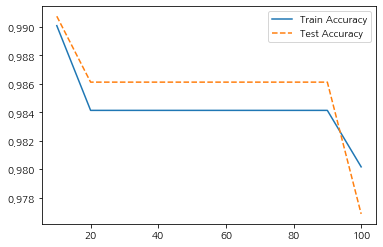

In [80]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

### 20이하를 확대

In [81]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*2 for n_split in range(1,11)]

for v_para_split in para_split:
    gb = GradientBoostingClassifier(learning_rate = 0.4,n_estimators = 4,min_samples_split = v_para_split,max_depth=6,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

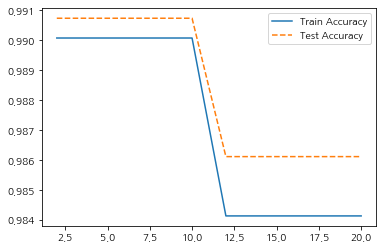

In [82]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [83]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,2,0.990,0.991
1,4,0.990,0.991
2,6,0.990,0.991
3,8,0.990,0.991
4,10,0.990,0.991
5,12,0.984,0.986
6,14,0.984,0.986
7,16,0.984,0.986
8,18,0.984,0.986
9,20,0.984,0.986


#### 분석 : train이 test의 정확도보다 높으면서 서로 차이가 많이 나지 않는 11을 선택하였다.

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [84]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_para_leaf in para_leaf:
    gb = GradientBoostingClassifier(learning_rate = 0.4,n_estimators = 4,min_samples_leaf = v_para_leaf,min_samples_split = 11,max_depth=6,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy
df_accuracy_leaf['Train-Test'] = df_accuracy_leaf['TrainAccuracy']-df_accuracy_leaf['TestAccuracy']

In [85]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy,Train-Test
0,2,0.992,0.991,0.001
1,4,0.986,0.995,-0.009
2,6,0.984,0.991,-0.007
3,8,0.978,0.991,-0.013
4,10,0.980,0.991,-0.011
5,12,0.978,0.991,-0.013
6,14,0.978,0.977,0.001
7,16,0.976,0.963,0.013
8,18,0.968,0.972,-0.004
9,20,0.972,0.968,0.005


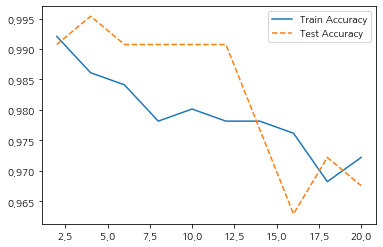

In [86]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : train의 정확도가 1이 아니면서 test와 차이가 가장 적은 14를 선택

### 최종 모델

In [87]:
gb_final = GradientBoostingClassifier(learning_rate = 0.4,n_estimators = 4,max_depth=6,min_samples_split=11,min_samples_leaf=14,random_state=1234)
gb_final.fit(df_train_x,df_train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=14, min_samples_split=11,
                           min_weight_fraction_leaf=0.0, n_estimators=4,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [88]:
v_feature_name = df_train_x.columns

In [89]:
y_pred = gb_final.predict(df_test_x)

print(gb_final.score(df_train_x,df_train_y))
print(gb_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

0.9781746031746031
0.9768518518518519
[[144   1]
 [  4  67]]


Text(0, 0.5, '설명변수')

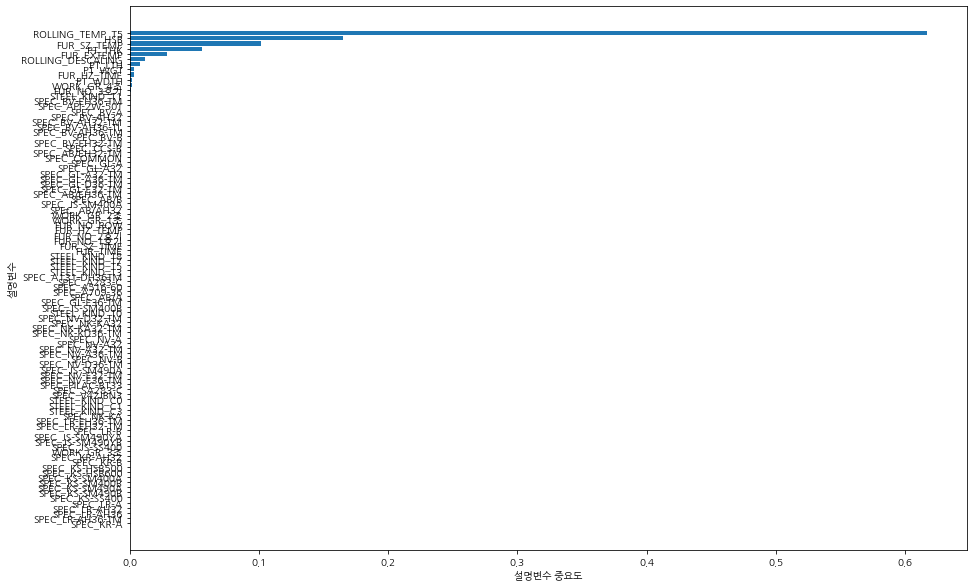

In [90]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

plt.figure(figsize=(15,10))
df_importance.sort_values('Importance',ascending = True,inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width = df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

In [91]:
df_train_x.columns

Index(['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'SPEC_A131-DH36TM',
       'SPEC_A283-C', 'SPEC_A516-60', 'SPEC_A709-36', 'SPEC_AB/A',
       'SPEC_AB/AH32', 'SPEC_AB/B', 'SPEC_AB/EH32-TM', 'SPEC_AB/EH36-TM',
       'SPEC_API-2W-50T', 'SPEC_BV-A', 'SPEC_BV-AH32', 'SPEC_BV-AH32-TM',
       'SPEC_BV-AH36-TL', 'SPEC_BV-AH36-TM', 'SPEC_BV-B', 'SPEC_BV-EH32-TM',
       'SPEC_BV-EH36-TM', 'SPEC_CCS-B', 'SPEC_COMMON', 'SPEC_GL-A',
       'SPEC_GL-A32', 'SPEC_GL-A32-TM', 'SPEC_GL-A36-TM', 'SPEC_GL-D36-TM',
       'SPEC_GL-E32-TM', 'SPEC_GL-E36-TM', 'SPEC_JS-SM400A', 'SPEC_JS-SM400B',
       'SPEC_JS-SM490A', 'SPEC_JS-SM490YA', 'SPEC_JS-SM490YB', 'SPEC_JS-SS400',
       'SPEC_KR-A', 'SPEC_KR-AH32', 'SPEC_KR-B', 'SPEC_KS-HSB500',
       'SPEC_KS-HSB600', 'SPEC_KS-SM400A', 'SPEC_KS-SM400B', 'SPEC_KS-SM490A',
       'SPEC_KS-SM490B', 'SPEC

#### 분석 : 목표변수와 관계가 가장 높은 설명변수를 순서대로 나열하면 다음과 같다. ROLLING_TEMP_T5, HSB, FUR_SZ_TEMP, PT_THK, FUR_EXTEMP, ROLLING_DESCALING

### 회귀분석

### 데이터 전처리

In [92]:
df_raw = pd.read_csv('SCALE불량.csv',encoding = 'cp949',parse_dates=['ROLLING_DATE'])
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [93]:
df_raw = df_raw.drop(['PLATE_NO','ROLLING_DATE'],axis = 1)
df_raw['SCALE'] = np.where(df_raw['SCALE']=='양품',0,1)

In [94]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


In [95]:
df_train,df_test = train_test_split(df_raw,test_size = 0.3,random_state = 1234)

print('train data size:{}'.format(df_train.shape))
print('test data size:{}'.format(df_test.shape))

train data size:(504, 19)
test data size:(216, 19)


In [96]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 19 columns):
SCALE                720 non-null int64
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null object
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(13), object(5)
memory usage: 107.0+ KB


In [97]:
log_model = Logit.from_formula('''SCALE ~ PT_THK+PT_WDTH+PT_LTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW
+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+C(HSB)+ROLLING_DESCALING+C(WORK_GR)''',df_train)

log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.258678
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                           18
Date:                Sat, 02 Nov 2019   Pseudo R-squ.:                  0.5861
Time:                        04:38:14   Log-Likelihood:                -130.37
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 2.368e-67
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -87.3458        nan        nan        nan         nan         nan
C(FUR_NO)[T.2호기]      0.1144      0.337     

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### 예측및 성능 평가

In [98]:
y_pred = log_result.predict(df_test)

y_pred_class = (y_pred>0.5).astype(int)
y_pred_class.head()

146    1
131    1
650    0
613    1
355    0
dtype: int64

In [99]:
print('Accuracy:{0:.3f}\n'.format(accuracy_score(df_test['SCALE'],y_pred_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test['SCALE'],y_pred_class)))

Accuracy:0.861

Confusion Matrix:
[[125  20]
 [ 10  61]]


### 결론 도출

/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


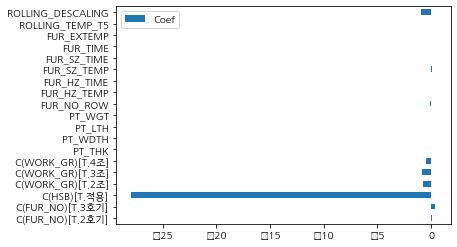

In [100]:
df_logitic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]},index = log_model.exog_names[1:])
df_logitic_coef.plot.barh(y='Coef')

In [101]:
df_logitic_coef

,Coef
C(FUR_NO)[T.2호기],0.114444
C(FUR_NO)[T.3호기],0.403033
C(HSB)[T.적용],-27.960126
C(WORK_GR)[T.2조],-0.797263
C(WORK_GR)[T.3조],-0.849731
C(WORK_GR)[T.4조],-0.506043
PT_THK,-0.036937
PT_WDTH,-0.001163
PT_LTH,-0.000037
PT_WGT,-0.000004


#### 분석 : 목표변수와 관계가 가장 높은 설명변수를 순서대로 나열하면 다음과 같다. 

### scale

In [102]:
df_char = df_raw.select_dtypes(include = 'object')
df_numeric = df_raw.select_dtypes(exclude = 'object')
#표준화 할때 범주형은 해당사항이 아님.

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled,columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled,df_char],axis = 1)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,-0.687308,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,-0.409268,-0.949149,0.000734,-0.19693,AB/EH32-TM,T1,1호기,적용,2조
1,-0.687308,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,-0.387221,-0.835252,0.028567,-0.19693,AB/EH32-TM,T1,1호기,적용,2조
2,-0.687308,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,-0.409268,-1.632537,-0.416748,-0.19693,NV-E36-TM,T8,2호기,적용,3조
3,-0.687308,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,0.340311,-1.290843,-0.453858,-0.19693,NV-E36-TM,T8,2호기,적용,3조
4,-0.687308,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,0.296219,-1.233894,-0.565186,-0.19693,BV-EH36-TM,T8,3호기,적용,1조


In [103]:
df_scaled['SCALE'] = np.where(df_scaled['SCALE']>0,1,0)
df_scaled['HSB'] = np.where(df_scaled['HSB']=='적용',1,0)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,-0.409268,-0.949149,0.000734,-0.19693,AB/EH32-TM,T1,1호기,1,2조
1,0,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,-0.387221,-0.835252,0.028567,-0.19693,AB/EH32-TM,T1,1호기,1,2조
2,0,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,-0.409268,-1.632537,-0.416748,-0.19693,NV-E36-TM,T8,2호기,1,3조
3,0,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,0.340311,-1.290843,-0.453858,-0.19693,NV-E36-TM,T8,2호기,1,3조
4,0,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,0.296219,-1.233894,-0.565186,-0.19693,BV-EH36-TM,T8,3호기,1,1조


In [104]:
df_scaled_train,df_scaled_test = train_test_split(df_scaled,test_size = 0.3,random_state = 1234)

In [105]:
scaled_log_model = Logit.from_formula('''SCALE ~ PT_THK+PT_WDTH+PT_LTH+PT_WGT+C(FUR_NO)+HSB+FUR_NO_ROW
+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+ROLLING_DESCALING+C(WORK_GR)''',df_scaled_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

         Current function value: 0.258678
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                           18
Date:                Sat, 02 Nov 2019   Pseudo R-squ.:                  0.5861
Time:                        04:38:18   Log-Likelihood:                -130.37
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 2.368e-67
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            31.7153   2.89e+05      0.000      1.000   -5.67e+05    5.67e+05
C(FUR_NO)[T.2호기]      0.1144      0.397     

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


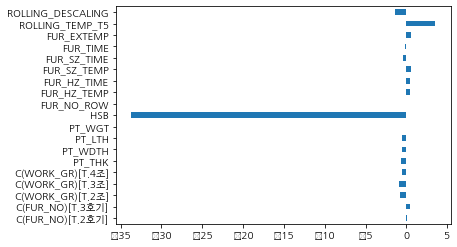

In [106]:
df_log_scaled_coef = pd.DataFrame({'Coef':scaled_log_result.params.values[1:]},index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = 'Coef',legend=False)

In [107]:
df_log_scaled_coef

,Coef
C(FUR_NO)[T.2호기],0.114444
C(FUR_NO)[T.3호기],0.403033
C(WORK_GR)[T.2조],-0.797263
C(WORK_GR)[T.3조],-0.849731
C(WORK_GR)[T.4조],-0.506043
PT_THK,-0.706947
PT_WDTH,-0.601832
PT_LTH,-0.514968
PT_WGT,-0.103677
HSB,-33.722900


#### 분석 : HSB가 다른 변수들에 비해서 압도적으로 영향을 많이 주므로 HSB를 제외하고 회귀분석을 실행해본다.

In [108]:
scaled_log_model = Logit.from_formula('''SCALE ~ PT_THK+PT_WDTH+PT_LTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW
+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+ROLLING_DESCALING+C(WORK_GR)''',df_scaled_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.350745
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      486
Method:                           MLE   Df Model:                           17
Date:                Sat, 02 Nov 2019   Pseudo R-squ.:                  0.4388
Time:                        04:38:19   Log-Likelihood:                -176.78
converged:                       True   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 8.193e-49
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.3943      0.344     -4.057      0.000      -2.068      -0.721
C(FUR_NO

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


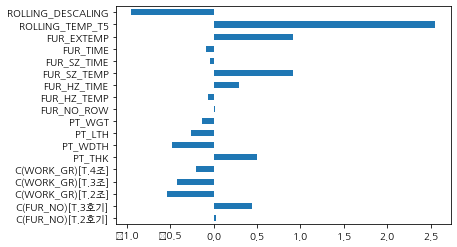

In [109]:
df_log_scaled_coef = pd.DataFrame({'Coef':scaled_log_result.params.values[1:]},index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = 'Coef',legend=False)

In [110]:
df_log_scaled_coef

,Coef
C(FUR_NO)[T.2호기],0.029231
C(FUR_NO)[T.3호기],0.438806
C(WORK_GR)[T.2조],-0.536824
C(WORK_GR)[T.3조],-0.421195
C(WORK_GR)[T.4조],-0.202661
PT_THK,0.498038
PT_WDTH,-0.475428
PT_LTH,-0.257134
PT_WGT,-0.132080
FUR_NO_ROW,0.021845


#### 분석 : 목표변수에 영향력이 큰 설명변수를 순서대로 나열하면 다음과 같다. ROLLING_TEMP_T5, ROLLING_DESCALING, FUR_SZ_TEMP==FUR_EXTEMP, C(WORK_GR)[T.-0.449573467485695] 이때 HSB가 제일 영향을 많이 준다고 되어있으나 p-value가 0.05보다 크므로 유의하지 않다고 판단하여 제외

### 모델링별 영향인자 정리

#### 회귀분석 : HSB, ROLLING_TEMP_T5, ROLLING_DESCALING, FUR_SZ_TEMP==FUR_EXTEMP, C(WORK_GR)[T.-0.449573467485695],PT_THK

#### 의사결정나무: ROLLING_TEMP_T5, HSB, FUR_SZ_TEMP, ROLLING_DESCALING, FUR_TIME, PT_LTH

#### 랜덤포레스트 : ROLLING_TEMP_T5, STEEL_KIND_C0, PT_WDTH,PT_LTH,FUR_SZ_TEP,ROLLING_DESCALING,FUR_EXTEMP,HSB

#### 그래디언트 부스팅 : ROLLING_TEMP_T5, HSB, FUR_SZ_TEMP, PT_THK, FUR_EXTEMP, ROLLING_DESCALING

#### 비교해본 결과 영향을 주는 인자로 HSB, ROLLING_TEMP_T5, ROLLING_DESCALING, FUR_SZ_TEMP, FUR_EXTEMP,PT_THK을 선택하였다.

### 영향인자 확인해보기

In [220]:
df_raw = pd.read_csv('SCALE불량.csv',encoding = 'cp949')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [221]:
df_raw['SPEC_TYPE'] = df_raw['SPEC'].str[:2]
df_raw = df_raw.drop(['PLATE_NO','ROLLING_DATE','SPEC'],axis = 1)
df_raw['ROLLING_TEMP_T5'] = df_raw['ROLLING_TEMP_T5'].replace(0,905.400818)

In [222]:
df_raw.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC_TYPE
0,양품,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934.0,적용,8,2조,AB
1,양품,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937.0,적용,8,2조,AB
2,양품,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889.0,적용,8,3조,NV
3,양품,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885.0,적용,8,3조,NV
4,양품,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873.0,적용,8,1조,BV


In [223]:
df_raw.groupby(['SPEC_TYPE','SCALE']).size()

SPEC_TYPE  SCALE
A1         불량        1
A2         불량        5
           양품        1
A5         불량        1
           양품        1
A7         양품        1
AB         불량        9
           양품       28
AP         양품        2
BV         불량       14
           양품       72
CC         불량        1
CO         불량        2
           양품       26
GL         불량        7
           양품       49
JS         불량       86
           양품       60
KR         불량       18
           양품       13
KS         불량       16
           양품       12
LR         불량       28
           양품       77
NK         불량        3
           양품       17
NV         불량       27
           양품       78
PI         불량        2
           양품       38
SA         불량       10
           양품       11
V4         불량        1
           양품        3
dtype: int64

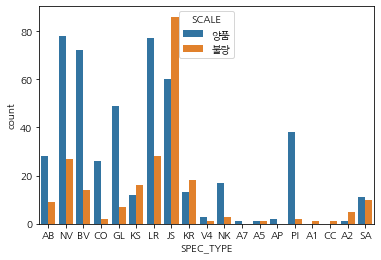

In [224]:
sns.countplot("SPEC_TYPE",hue="SCALE", data = df_raw)

#### 분석 : 위의 그래프를 본 결과 spec type가 scale에 큰 영향을 준다고 볼 수 없다. 각 spec type별 불량과 양품의 비율이 다른것은 spec type이 원인이 아닌 다른 변수들이 더 큰 영향을 주었다고 볼 수 있다.

### ANOVA 확인하기

분석 통계량 => 
statistic:(F) 317.487, p-value: 0.000


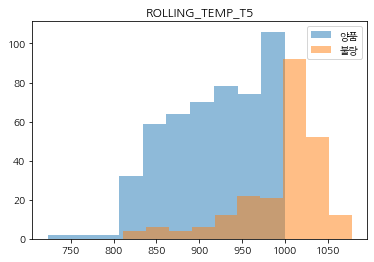

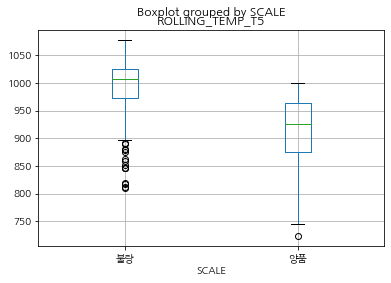

In [227]:
v_yvar = 'SCALE'
v_xvar='ROLLING_TEMP_T5'

fv,pv = fun_anova(v_data = df_raw,yvar = v_yvar,xvar = v_xvar)
fun_plot_hist(v_data=df_raw,yvar=v_yvar,xvar=v_xvar)

df_raw.boxplot(column = v_xvar,by = v_yvar,figsize = (6,4))

#### 분석 : p-value가 0.05보다 낮으므로 유의한 그래프라고 볼 수 있다. 이때 1000이후로는 불량만 발생하므로 ROLLING_TEMP_T5는 1000이하여야 한다.

In [228]:
df_raw['HSB'] = np.where(df_raw['HSB']=='미적용',0,1)

분석 통계량 => 
statistic:(F) 81.274, p-value: 0.000


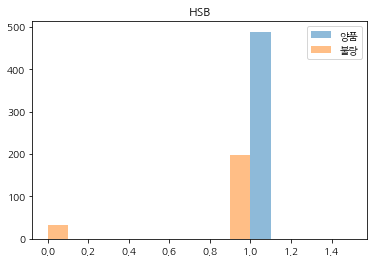

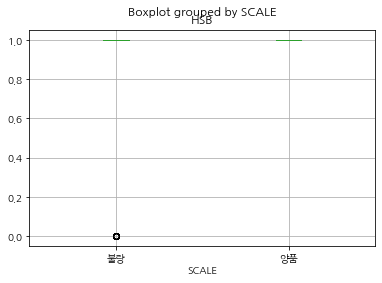

In [229]:
v_yvar = 'SCALE'
v_xvar='HSB'

fv,pv = fun_anova(v_data = df_raw,yvar = v_yvar,xvar = v_xvar)
fun_plot_hist(v_data=df_raw,yvar=v_yvar,xvar=v_xvar)

df_raw.boxplot(column = v_xvar,by = v_yvar,figsize = (6,4))

#### 분석 : p-value값이 0으로 0.05보다 작으므로 HSB는 SCALE에 영향을 많이 주는 인자가 맞다. HSB가 미적용일때 SCALE은 불량이 나온다.

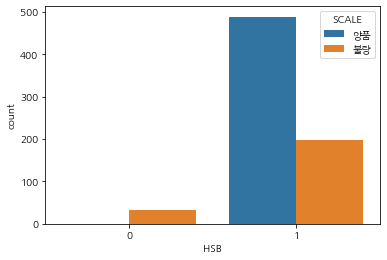

In [230]:
sns.countplot("HSB",hue="SCALE", data = df_raw)

분석 통계량 => 
statistic:(F) 0.035, p-value: 0.852


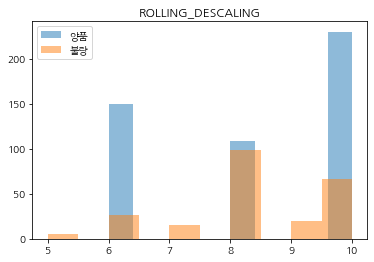

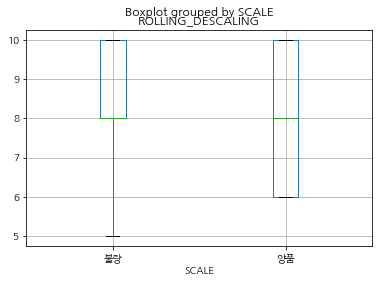

In [231]:
v_yvar = 'SCALE'
v_xvar='ROLLING_DESCALING'

fv,pv = fun_anova(v_data = df_raw,yvar = v_yvar,xvar = v_xvar)
fun_plot_hist(v_data=df_raw,yvar=v_yvar,xvar=v_xvar)

df_raw.boxplot(column = v_xvar,by = v_yvar,figsize = (6,4))

#### 분석 : p-value의 값이 0.05보다 훨씬 큰 값을 가진다. 앞에서 영향인자를 추출했을때 높은 설명변수로 나온것과는 모순이다. 고민해본 결과 ROLLING_DESCALING이 scale에 영향을 주지만 아노바의 특징상 여러 변수들과의 관계를 나타내는 것으로 변수가 둘뿐이라 p-value가 크게 나온것으로 볼 수 있다.

분석 통계량 => 
statistic:(F) 117.352, p-value: 0.000


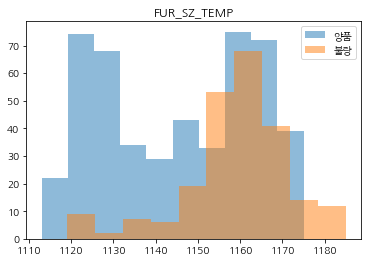

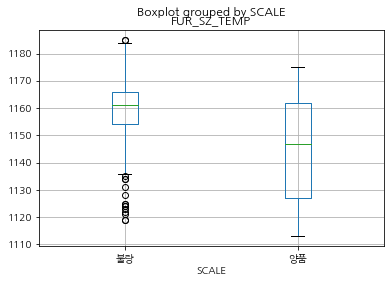

In [232]:
v_yvar = 'SCALE'
v_xvar='FUR_SZ_TEMP'

fv,pv = fun_anova(v_data = df_raw,yvar = v_yvar,xvar = v_xvar)
fun_plot_hist(v_data=df_raw,yvar=v_yvar,xvar=v_xvar)

df_raw.boxplot(column = v_xvar,by = v_yvar,figsize = (6,4))

In [233]:
len(df_raw[(df_raw['FUR_SZ_TEMP']>1150)&(df_raw['SCALE']=='불량')])/len(df_raw[df_raw['SCALE']=='불량'])

0.8311688311688312

#### 분석 : p-value값이 0.05보다 크므로 유의한 그래프라고 볼 수 있다. 전체 불량 중 FUR_SZ_TEMP가 1150넘을때 불량인 경우가 83.1%에 해당한다. 따라서 되도록이면 FUR_SZ_TEMP가 1150이하로 해야 한다.

분석 통계량 => 
statistic:(F) 117.352, p-value: 0.000


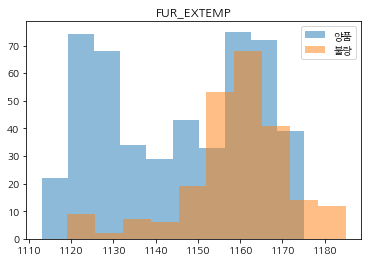

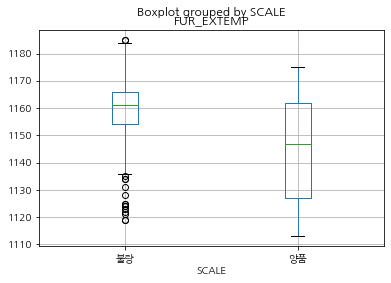

In [234]:
v_yvar = 'SCALE'
v_xvar='FUR_EXTEMP'

fv,pv = fun_anova(v_data = df_raw,yvar = v_yvar,xvar = v_xvar)
fun_plot_hist(v_data=df_raw,yvar=v_yvar,xvar=v_xvar)

df_raw.boxplot(column = v_xvar,by = v_yvar,figsize = (6,4))

#### 분석 : FUR_EXTEMP와 FUR_SZ_TEMP는 모두 같은 값을 가진다.

In [235]:
len(df_raw[(df_raw['FUR_EXTEMP']>1150)&(df_raw['SCALE']=='불량')])/len(df_raw[df_raw['SCALE']=='불량'])

0.8311688311688312

분석 통계량 => 
statistic:(F) 11.371, p-value: 0.001


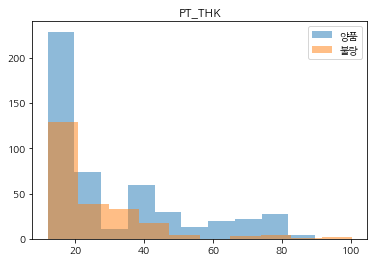

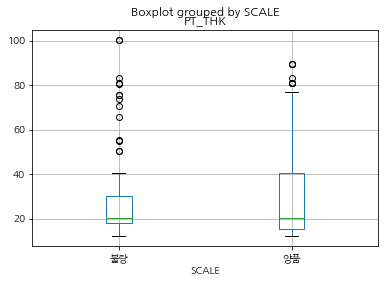

In [236]:
v_yvar = 'SCALE'
v_xvar='PT_THK'

fv,pv = fun_anova(v_data = df_raw,yvar = v_yvar,xvar = v_xvar)
fun_plot_hist(v_data=df_raw,yvar=v_yvar,xvar=v_xvar)

df_raw.boxplot(column = v_xvar,by = v_yvar,figsize = (6,4))

In [237]:
len(df_raw[(df_raw['PT_THK']>60)&(df_raw['SCALE']=='불량')])/len(df_raw[df_raw['SCALE']=='불량'])

0.04329004329004329

In [238]:
len(df_raw[(df_raw['PT_THK']>60)&(df_raw['SCALE']=='양품')])/len(df_raw[df_raw['SCALE']=='양품'])

0.1492842535787321

In [239]:
len(df_raw[(df_raw['PT_THK']<40)&(df_raw['SCALE']=='불량')])/len(df_raw[df_raw['SCALE']=='불량'])

0.8658008658008658

In [240]:
len(df_raw[(df_raw['PT_THK']<20)&(df_raw['SCALE']=='불량')])/len(df_raw[df_raw['SCALE']=='불량'])

0.3722943722943723

In [241]:
len(df_raw[((df_raw['PT_THK']<40)&(df_raw['PT_THK']>20))&(df_raw['SCALE']=='불량')])/len(df_raw[df_raw['SCALE']=='불량'])

0.4935064935064935

In [242]:
len(df_raw[((df_raw['PT_THK']<40)&(df_raw['PT_THK']>20))&(df_raw['SCALE']=='양품')])/len(df_raw[df_raw['SCALE']=='양품'])

0.22085889570552147

#### 분석 : p-value가 0.05보다 낮으므로 PT_THK가 양품과 불량에 차이를 준다고 볼 수 있다. 위의 그래프에서 PT_THK가 20에서 40사이일때 전체 양품 중 양품일 확률은 22%에 불과했다. 반대로 전체 불량 중 불량일 확률은 49.3%로 불량 중 절반을 차지한다. 따라서PT_THK은 20과 40을 제작하지 않도록 한다. 

### HSB, ROLLING_TEMP_T5, ROLLING_DESCALING, FUR_SZ_TEMP= FUR_EXTEMP,PT_THK 

### 모델링

In [134]:
df_model = df_raw[['HSB','ROLLING_TEMP_T5','ROLLING_DESCALING','FUR_EXTEMP','PT_THK']]

In [135]:
df_model.head()

,HSB,ROLLING_TEMP_T5,ROLLING_DESCALING,FUR_EXTEMP,PT_THK
0,1,934.0,8,1133,32.25
1,1,937.0,8,1135,32.25
2,1,889.0,8,1121,33.27
3,1,885.0,8,1127,33.27
4,1,873.0,8,1128,38.33


In [136]:
df_model['HSB'] = np.where(df_model['HSB']=='미적용',0,1)

/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
df_model.head()

,HSB,ROLLING_TEMP_T5,ROLLING_DESCALING,FUR_EXTEMP,PT_THK
0,1,934.0,8,1133,32.25
1,1,937.0,8,1135,32.25
2,1,889.0,8,1121,33.27
3,1,885.0,8,1127,33.27
4,1,873.0,8,1128,38.33


In [138]:
df_raw_x = df_model
df_raw_y = df_raw['SCALE']

### 데이터 분할

In [139]:
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size = 0.3,random_state = 1234)

print('Train data X size:{}'.format(df_train_x.shape))
print('test data X size:{}'.format(df_test_x.shape))
print('Train data y size:{}'.format(df_train_y.shape))
print('test data y size:{}'.format(df_test_y.shape))

Train data X size:(504, 5)
test data X size:(216, 5)
Train data y size:(504,)
test data y size:(216,)


### 모델생성

In [140]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print(tree_uncustomized.score(df_train_x,df_train_y))
print(tree_uncustomized.score(df_test_x,df_test_y))

1.0
0.9120370370370371


#### 분석 : train의 경우 1이므로 overfitting으로 볼 수 있으므로 parameter를 조정해준다.

### Parameter조정

### Depth조정

In [141]:
train_accuracy = [];test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth=v_max_depth,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

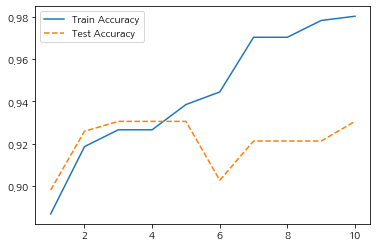

In [142]:
plt.plot(para_depth,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [143]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.887,0.898
1,2,0.919,0.926
2,3,0.927,0.931
3,4,0.927,0.931
4,5,0.938,0.931
5,6,0.944,0.903
6,7,0.970,0.921
7,8,0.970,0.921
8,9,0.978,0.921
9,10,0.980,0.931


#### 분석 : train이 1이 아니면서 train과 test의 값이 가까운 6을 선택하였다.

### min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [144]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*10 for n_split in range(1,11)]

for v_para_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_para_split,max_depth=6,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

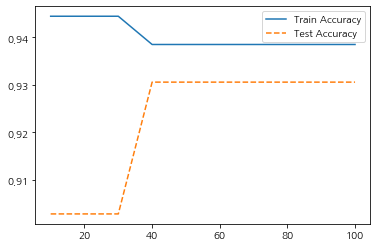

In [145]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [146]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.944,0.903
1,20,0.944,0.903
2,30,0.944,0.903
3,40,0.938,0.931
4,50,0.938,0.931
5,60,0.938,0.931
6,70,0.938,0.931
7,80,0.938,0.931
8,90,0.938,0.931
9,100,0.938,0.931


#### 분석 : test의 경우에는 0.977로 변화가 없으므로 train을 기준으로 급감하기 이전인 90을 선택하였다.

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [147]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_para_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_para_leaf,min_samples_split = 90,max_depth=6,random_state = 1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy
df_accuracy_leaf['Train - Test'] = df_accuracy_leaf['TrainAccuracy']-df_accuracy_leaf['TestAccuracy']

In [148]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy,Train - Test
0,2,0.938,0.931,0.008
1,4,0.938,0.931,0.008
2,6,0.931,0.926,0.005
3,8,0.919,0.926,-0.007
4,10,0.919,0.926,-0.007
5,12,0.919,0.926,-0.007
6,14,0.919,0.926,-0.007
7,16,0.919,0.926,-0.007
8,18,0.915,0.921,-0.007
9,20,0.905,0.917,-0.012


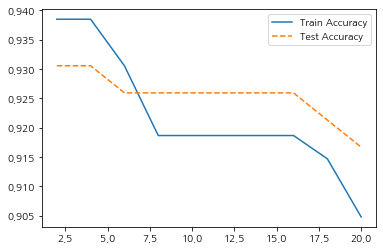

In [149]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

#### 분석 : test의 score가 4를 기점으로 급격하게 증가한다. 따라서 급증하기 전 train과의 차이가 가장 적은 값인 4를 선택하였다.

### 최종 모델

In [150]:
tree_final = DecisionTreeClassifier(max_depth=6,min_samples_split=90,min_samples_leaf=4,random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=90,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [151]:
v_feature_name = df_raw_x.columns

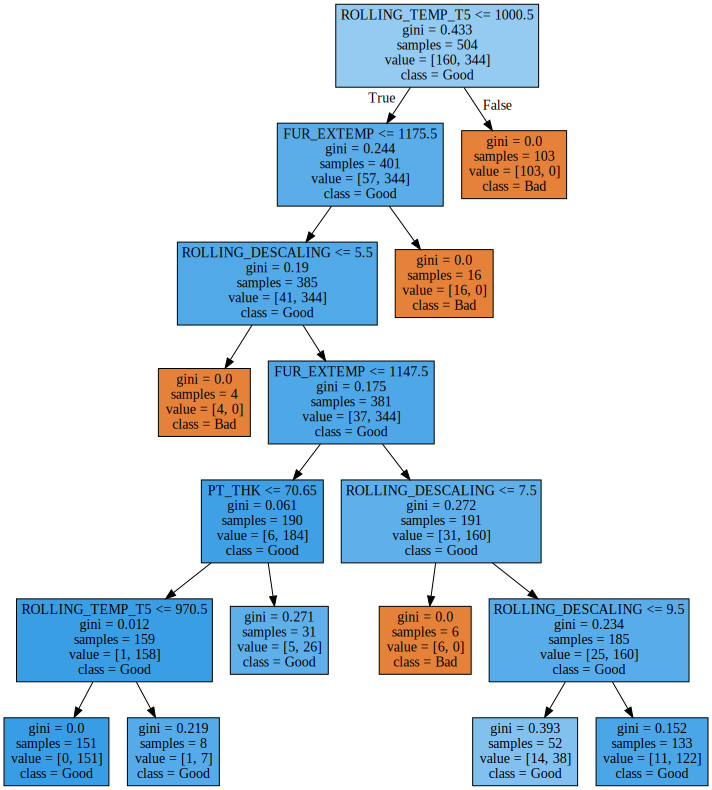

In [152]:
export_graphviz(tree_final,out_file = 'tree_low.dot',class_names = ['Bad','Good'],
               feature_names = v_feature_name,impurity=True,filled = True)

with open('tree_low.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### 분석 : 압연온도가1000.5 도가 넘어가고 HSB가 미적용일때는 모두 불량으로 나타났다. 이후 양품중에서 추출온도가 1175.5도가 넘어가면 모두 불량이 나왔다.

### 최종 모델평가

In [153]:
y_pred = tree_final.predict(df_test_x)
print('Test score:',tree_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

Test score: 0.9305555555555556
[[ 57  14]
 [  1 144]]


### 결론도출

Text(0, 0.5, '설명변수')

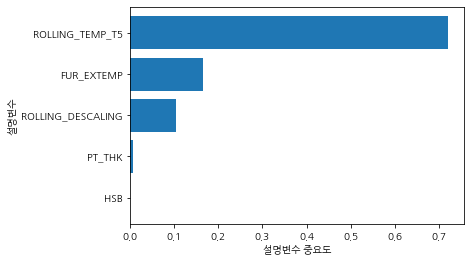

In [154]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance',ascending = True,inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width = df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

In [155]:
df_importance

,Feature,Importance
0,HSB,0.000000
4,PT_THK,0.007436
2,ROLLING_DESCALING,0.105880
3,FUR_EXTEMP,0.165739
1,ROLLING_TEMP_T5,0.720945


#### 분석 : 압연온도가  0.619로 절반이상의 중요도를 가진다. 즉 압연온도에 따라서 불량과 양품을 크게 좌지우지 할 수 있다. 

### 랜덤포레스트

### 모델생성

In [156]:
tree_uncustomized = RandomForestClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print(tree_uncustomized.score(df_train_x,df_train_y))
print(tree_uncustomized.score(df_test_x,df_test_y))

1.0
0.9351851851851852


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### 분석 : train의 score가 1이므로 과적화이다.

### Parameter조정

### n_estimators: 트리 수 변경에 따른 모델 성능

In [157]:
train_accuracy = [];test_accuracy = []
para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

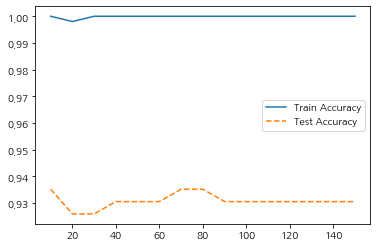

In [158]:
plt.plot(para_n_tree,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()


In [159]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,1.000,0.935
1,20,0.998,0.926
2,30,1.000,0.926
3,40,1.000,0.931
4,50,1.000,0.931
5,60,1.000,0.931
6,70,1.000,0.935
7,80,1.000,0.935
8,90,1.000,0.931
9,100,1.000,0.931


#### 분석 : train이 모두 1이므로 test와 차이가 적으면서 test가 1이 아닌 수로 85를 택하였다.

### 트리 수 변경에 따른 모델oob error변화

In [160]:
oob_error = []

for v_n_estimator in range(1,100):
    rf = RandomForestClassifier(n_estimators = v_n_estimator,oob_score = True,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    oob_error.append(1-rf.oob_score_)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not hav

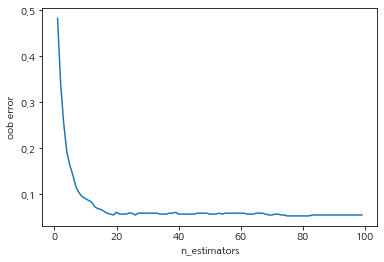

In [161]:
plt.plot(range(1,100),oob_error)
plt.ylabel('oob error')
plt.xlabel('n_estimators')
n_estimators = 85

#### 분석 : oob error를 확인해본 결과 85개 일때도 오류가 적었으므로 85개를 선택을 확신하였다.

### Depth조정

In [162]:
train_accuracy = [];test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(n_estimators = 85,max_depth=v_max_depth,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy
df_accuracy_depth['Train-Test'] = df_accuracy_depth['TrainAccuracy']-df_accuracy_depth['TestAccuracy']

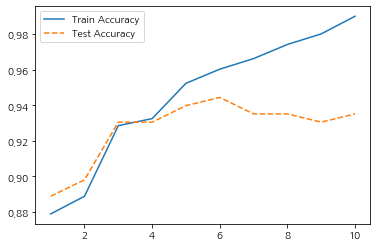

In [163]:
plt.plot(para_depth,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [164]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy,Train-Test
0,1,0.879,0.889,-0.010
1,2,0.889,0.898,-0.009
2,3,0.929,0.931,-0.002
3,4,0.933,0.931,0.002
4,5,0.952,0.940,0.013
5,6,0.960,0.944,0.016
6,7,0.966,0.935,0.031
7,8,0.974,0.935,0.039
8,9,0.980,0.931,0.050
9,10,0.990,0.935,0.055


#### 분석 : train과 test는 모두 꾸준히 상승한다. 이중에서 train과 test의 차이가 가장 적은 5를 선택하였다.

### min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [165]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*10 for n_split in range(1,11)]

for v_para_split in para_split:
    rf = RandomForestClassifier(n_estimators = 85,min_samples_split = v_para_split,max_depth=5,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

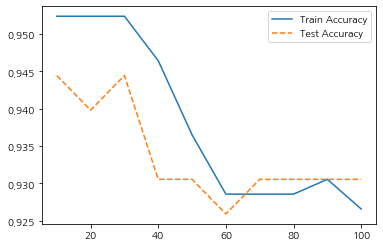

In [166]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [167]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.952,0.944
1,20,0.952,0.940
2,30,0.952,0.944
3,40,0.946,0.931
4,50,0.937,0.931
5,60,0.929,0.926
6,70,0.929,0.931
7,80,0.929,0.931
8,90,0.931,0.931
9,100,0.927,0.931


#### 분석 : test의 score는 0.977로 변함이 없다. 따라서 train을 기준으로 train과 test의 차이가 가장 적은 20을 선택하였다.

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [168]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_para_leaf in para_leaf:
    rf = RandomForestClassifier(n_estimators = 85,min_samples_leaf = v_para_leaf,min_samples_split = 20,max_depth=5,random_state = 1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    test_accuracy.append(rf.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy
df_accuracy_leaf['Train-Test'] = df_accuracy_leaf['TrainAccuracy']-df_accuracy_leaf['TestAccuracy']

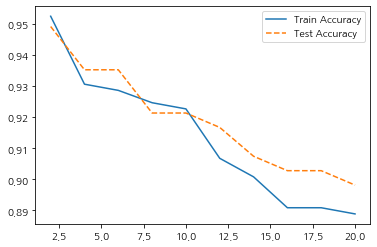

In [169]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [170]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy,Train-Test
0,2,0.952,0.949,0.003
1,4,0.931,0.935,-0.005
2,6,0.929,0.935,-0.007
3,8,0.925,0.921,0.003
4,10,0.923,0.921,0.001
5,12,0.907,0.917,-0.010
6,14,0.901,0.907,-0.007
7,16,0.891,0.903,-0.012
8,18,0.891,0.903,-0.012
9,20,0.889,0.898,-0.009


#### 분석 : train과 test가 꾸준히 감소한다. 이중에서 둘 사이의 차이가 가장 적은 14를 선택하였다.

### 최종 모델

In [171]:
rf_final = RandomForestClassifier(n_estimators = 85,max_depth=5,min_samples_split=20,min_samples_leaf=14,random_state=1234)
rf_final.fit(df_train_x,df_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=14, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=85,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [172]:
y_pred = rf_final.predict(df_test_x)

print('Train Score:',rf_final.score(df_train_x,df_train_y))
print('Test Score:',rf_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

Train Score: 0.9007936507936508
Test Score: 0.9074074074074074
[[ 51  20]
 [  0 145]]


Text(0, 0.5, '설명변수')

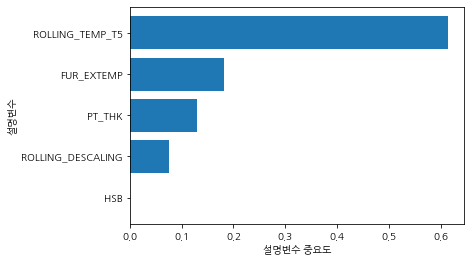

In [173]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values('Importance',ascending = True,inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width = df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

In [174]:
df_importance

,Feature,Importance
0,HSB,0.000000
2,ROLLING_DESCALING,0.075057
4,PT_THK,0.129791
3,FUR_EXTEMP,0.181044
1,ROLLING_TEMP_T5,0.614108


#### 분석 : 압연온도가 0.587로 가장 큰 중요도를 차지하였다.

### 그래디언트 부스팅

### 모델생성

In [175]:
tree_uncustomized = GradientBoostingClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print(tree_uncustomized.score(df_train_x,df_train_y))
print(tree_uncustomized.score(df_test_x,df_test_y))

0.9761904761904762
0.9398148148148148


#### 분석 : train과 test가 모두 1이므로 과적합으로 볼 수 있다.

### Parameter조정

### learning_rate : 학습률 변경에 따른 모델 성능

In [176]:
train_accuracy = [];test_accuracy = []
para_lr = [n_tree*0.1 for n_tree in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate=v_learning_rate,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

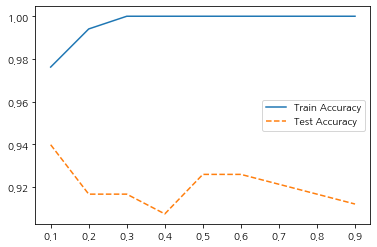

In [177]:
plt.plot(para_lr,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_lr,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [178]:
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,0.976,0.940
1,0.2,0.994,0.917
2,0.3,1.000,0.917
3,0.4,1.000,0.907
4,0.5,1.000,0.926
5,0.6,1.000,0.926
6,0.7,1.000,0.921
7,0.8,1.000,0.917
8,0.9,1.000,0.912


#### 분석 :  train이 1로 일정하다. 따라서 0.1을 선택하였다.

### n_estimators: 트리 수 변경에 따른 모델 성능

In [179]:
train_accuracy = [];test_accuracy = []
para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(learning_rate = 0.1,n_estimators=v_n_estimators,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy
df_accuracy_n['train-test'] = df_accuracy_n['TrainAccuracy']-df_accuracy_n['TestAccuracy']

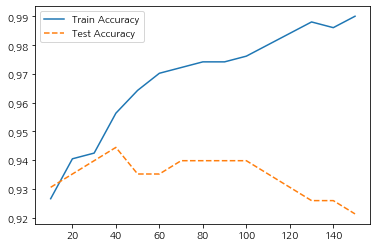

In [180]:
plt.plot(para_n_tree,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_n_tree,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [181]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy,train-test
0,10,0.927,0.931,-0.004
1,20,0.940,0.935,0.005
2,30,0.942,0.940,0.003
3,40,0.956,0.944,0.012
4,50,0.964,0.935,0.029
5,60,0.970,0.935,0.035
6,70,0.972,0.940,0.032
7,80,0.974,0.940,0.034
8,90,0.974,0.940,0.034
9,100,0.976,0.940,0.036


#### 분석 : train과 test가 모두 1이 아니면서 차이가 가장 적은 50을 선택하였다.

### Depth조정

In [182]:
train_accuracy = [];test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(learning_rate = 0.1,n_estimators = 50,max_depth=v_max_depth,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

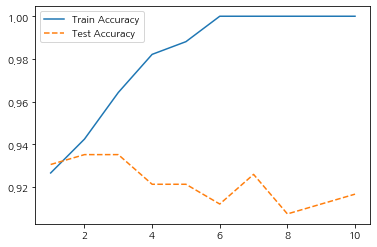

In [183]:
plt.plot(para_depth,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [184]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.927,0.931
1,2,0.942,0.935
2,3,0.964,0.935
3,4,0.982,0.921
4,5,0.988,0.921
5,6,1.000,0.912
6,7,1.000,0.926
7,8,1.000,0.907
8,9,1.000,0.912
9,10,1.000,0.917


#### 분석 : train과 test가 1이 아니면서 둘 사이의 값이 적은 3을 선택하였다.

### min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [185]:
train_accuracy = [];test_accuracy = []
para_split = [n_split*10 for n_split in range(1,11)]

for v_para_split in para_split:
    gb = GradientBoostingClassifier(learning_rate = 0.1,n_estimators = 50,min_samples_split = v_para_split,max_depth=3,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy
df_accuracy_split['Train-Test'] = df_accuracy_split['TrainAccuracy']-df_accuracy_split['TestAccuracy']

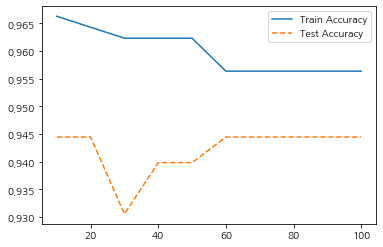

In [186]:
plt.plot(para_split,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_split,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [187]:
df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy,Train-Test
0,10,0.966,0.944,0.022
1,20,0.964,0.944,0.020
2,30,0.962,0.931,0.032
3,40,0.962,0.940,0.022
4,50,0.962,0.940,0.022
5,60,0.956,0.944,0.012
6,70,0.956,0.944,0.012
7,80,0.956,0.944,0.012
8,90,0.956,0.944,0.012
9,100,0.956,0.944,0.012


#### 분석 : train과 test의 차이가 적은 20을 선택하였다.

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [188]:
train_accuracy = [];test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_para_leaf in para_leaf:
    gb = GradientBoostingClassifier(learning_rate = 0.1,n_estimators = 50,min_samples_leaf = v_para_leaf,min_samples_split = 20,max_depth=3,random_state = 1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy
df_accuracy_leaf['Train-Test'] = df_accuracy_leaf['TrainAccuracy']-df_accuracy_leaf['TestAccuracy']

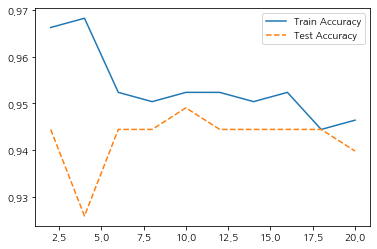

In [189]:
plt.plot(para_leaf,train_accuracy,linestyle = '-',label = 'Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle = '--',label = 'Test Accuracy')
plt.legend()

In [190]:
df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy,Train-Test
0,2,0.966,0.944,0.022
1,4,0.968,0.926,0.042
2,6,0.952,0.944,0.008
3,8,0.950,0.944,0.006
4,10,0.952,0.949,0.003
5,12,0.952,0.944,0.008
6,14,0.950,0.944,0.006
7,16,0.952,0.944,0.008
8,18,0.944,0.944,0.000
9,20,0.946,0.940,0.007


#### 분석 : train과 test가 높으면서 차이가 가장 적은 6을 선택하였다.

### 최종 모델

In [191]:
gb_final = GradientBoostingClassifier(learning_rate = 0.1,n_estimators = 50,max_depth=3,min_samples_split=20,min_samples_leaf=6,random_state=1234)
gb_final.fit(df_train_x,df_train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=6, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [192]:
y_pred = gb_final.predict(df_test_x)

print(gb_final.score(df_train_x,df_train_y))
print(gb_final.score(df_test_x,df_test_y))
print(confusion_matrix(df_test_y,y_pred))

0.9523809523809523
0.9444444444444444
[[ 60  11]
 [  1 144]]


Text(0, 0.5, '설명변수')

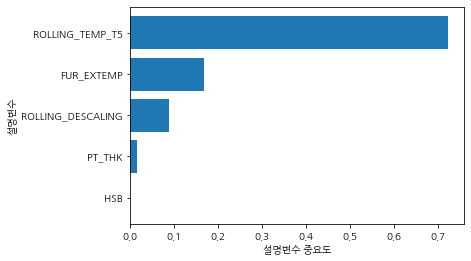

In [193]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values('Importance',ascending = True,inplace = True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width = df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

#### 분석 : test의 score가 모두 1에 수렴한다. 이때 압연온도가 가장 큰 중요도를 가진다.

### 회귀분석

### 모델 및 회귀계수 검토

In [194]:
df_raw.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR,SPEC_TYPE
0,양품,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934.0,1,8,2조,AB
1,양품,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937.0,1,8,2조,AB
2,양품,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889.0,1,8,3조,NV
3,양품,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885.0,1,8,3조,NV
4,양품,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873.0,1,8,1조,BV


In [195]:
df_train,df_test = train_test_split(df_raw,test_size = 0.3,random_state = 1234)

print('train data size:{}'.format(df_train.shape))
print('test data size:{}'.format(df_test.shape))

train data size:(504, 19)
test data size:(216, 19)


In [196]:
df_raw['SCALE'] = np.where(df_raw['SCALE']=='양품',0,1)

In [197]:
log_model = Logit.from_formula('''SCALE ~ C(HSB)+ROLLING_TEMP_T5+ROLLING_DESCALING+FUR_EXTEMP+PT_THK''',df_raw)

log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.290259
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  720
Model:                          Logit   Df Residuals:                      714
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Nov 2019   Pseudo R-squ.:                  0.5374
Time:                        04:39:05   Log-Likelihood:                -208.99
converged:                      False   LL-Null:                       -451.80
Covariance Type:            nonrobust   LLR p-value:                1.013e-102
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -85.3329   1.37e+04     -0.006      0.995   -2.69e+04    2.67e+04
C(HSB)[T.1]         -26.8441   1.37e+04     

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [198]:
y_pred = log_result.predict(df_test)

y_pred_class = (y_pred>0.5).astype(int)
y_pred_class.head()

146    1
131    1
650    0
613    1
355    0
dtype: int64

### 결론 도출

/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


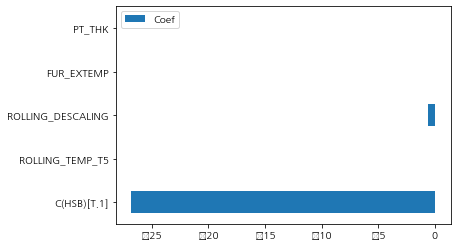

In [200]:
df_logitic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]},index = log_model.exog_names[1:])
df_logitic_coef.plot.barh(y='Coef')

### 결론도출-표준화 회귀계수

In [201]:
df_char = df_raw.select_dtypes(include = 'object')
df_numeric = df_raw.select_dtypes(exclude = 'object')
#표준화 할때 범주형은 해당사항이 아님.

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled,columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled,df_char],axis = 1)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,STEEL_KIND,FUR_NO,WORK_GR,SPEC_TYPE
0,-0.687308,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,-0.409268,-0.949149,-0.113854,0.219169,-0.19693,T1,1호기,2조,AB
1,-0.687308,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,-0.387221,-0.835252,-0.068104,0.219169,-0.19693,T1,1호기,2조,AB
2,-0.687308,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,-0.409268,-1.632537,-0.800105,0.219169,-0.19693,T8,2호기,3조,NV
3,-0.687308,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,0.340311,-1.290843,-0.861105,0.219169,-0.19693,T8,2호기,3조,NV
4,-0.687308,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,0.296219,-1.233894,-1.044105,0.219169,-0.19693,T8,3호기,1조,BV


In [202]:
df_scaled['SCALE'] = np.where(df_scaled['SCALE']>0,1,0)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,STEEL_KIND,FUR_NO,WORK_GR,SPEC_TYPE
0,0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.729972,-0.949149,-0.544097,-0.409268,-0.949149,-0.113854,0.219169,-0.19693,T1,1호기,2조,AB
1,0,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.889399,-0.835252,-0.708951,-0.387221,-0.835252,-0.068104,0.219169,-0.19693,T1,1호기,2조,AB
2,0,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.729972,-1.632537,-0.654000,-0.409268,-1.632537,-0.800105,0.219169,-0.19693,T8,2호기,3조,NV
3,0,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,0.969113,-1.290843,-0.296815,0.340311,-1.290843,-0.861105,0.219169,-0.19693,T8,2호기,3조,NV
4,0,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.208255,-1.233894,-0.846330,0.296219,-1.233894,-1.044105,0.219169,-0.19693,T8,3호기,1조,BV


In [203]:
df_scaled_train,df_scaled_test = train_test_split(df_scaled,test_size = 0.3,random_state = 1234)

In [204]:
scaled_log_model = Logit.from_formula('''SCALE ~ C(HSB)+ROLLING_TEMP_T5+ROLLING_DESCALING+FUR_EXTEMP+PT_THK''',df_scaled_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

         Current function value: 0.280802
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      498
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Nov 2019   Pseudo R-squ.:                  0.5507
Time:                        04:39:10   Log-Likelihood:                -141.52
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 8.174e-73
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        36.3283   8.26e+06    4.4e-06      1.000   -1.62e+07    1.62e+07
C(HSB)[T

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


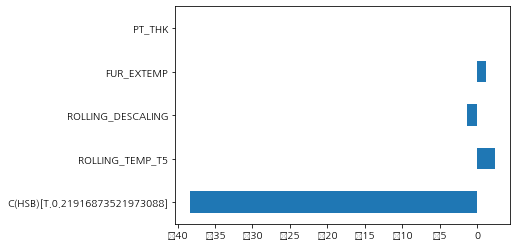

In [205]:
df_log_scaled_coef = pd.DataFrame({'Coef':scaled_log_result.params.values[1:]},index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = 'Coef',legend=False)

#### 분석 : 회귀분석에서는 HSB가 가장 큰 중요도를 보인다.

### 모델평가

In [206]:
df_model = df_raw[['SCALE','HSB','ROLLING_TEMP_T5','ROLLING_DESCALING','FUR_EXTEMP','PT_THK']]
df_model['HSB'] = np.where(df_model['HSB']=='미적용',0,1)
df_model['SCALE'] = np.where(df_model['SCALE']=='양품',0,1)
df_raw_y = df_raw['SCALE']

/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [207]:
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size = 0.3,random_state = 1234)

print(df_train_x.shape)
print(df_train_y.shape)
print(df_test_x.shape)
print(df_test_y.shape)

(504, 5)
(504,)
(216, 5)
(216,)


In [208]:
model = ['DecisionTree','RandomForest','GradientBoosting']

train_accuracy = [];test_accuracy=[]
model_f1_score = []
model_auc = []
model_precision=[]
model_recall=[]

### 분류모델 실행-의사결정나무

In [209]:
dt_model = DecisionTreeClassifier(max_depth=6,min_samples_split=90,min_samples_leaf=4,random_state=1234)
dt_model.fit(df_train_x,df_train_y)

train_accuracy.append(dt_model.score(df_train_x,df_train_y))
test_accuracy.append(dt_model.score(df_test_x,df_test_y))

y_pred = dt_model.predict(df_test_x)

fpr,tpr,thresholds = roc_curve(df_test_y,y_pred)
roc_auc = auc(fpr,tpr)

model_auc.append(roc_auc)
print(confusion_matrix(df_test_y,y_pred))

[[144   1]
 [ 14  57]]


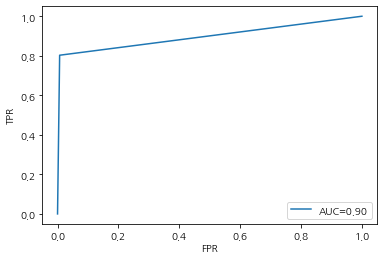

In [210]:
plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR');plt.xlabel('FPR')
plt.show()

In [211]:
model_precision.append(precision_score(df_test_y,y_pred))
model_recall.append(recall_score(df_test_y,y_pred))

model_f1_score.append(f1_score(df_test_y,y_pred))

### 랜덤포레스트

In [212]:
rf_model = RandomForestClassifier(n_estimators = 85,max_depth=5,min_samples_split=20,min_samples_leaf=14,random_state=1234)
rf_model.fit(df_train_x,df_train_y)

train_accuracy.append(rf_model.score(df_train_x,df_train_y))
test_accuracy.append(rf_model.score(df_test_x,df_test_y))

y_pred = rf_model.predict(df_test_x)

fpr,tpr,thresholds = roc_curve(df_test_y,y_pred)
roc_auc = auc(fpr,tpr)

model_auc.append(roc_auc)
print(confusion_matrix(df_test_y,y_pred))

[[145   0]
 [ 20  51]]


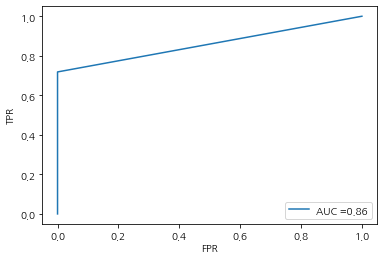

In [213]:
plt.plot(fpr,tpr,label='AUC =%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR');plt.xlabel('FPR')
plt.show()

In [214]:
model_precision.append(precision_score(df_test_y,y_pred))
model_recall.append(recall_score(df_test_y,y_pred))

model_f1_score.append(f1_score(df_test_y,y_pred))

### 그래디언트 부스팅

In [215]:
gb_model = GradientBoostingClassifier(learning_rate = 0.4,n_estimators = 4,max_depth=6,min_samples_split=11,min_samples_leaf=14,random_state=1234)
gb_model.fit(df_train_x,df_train_y)

train_accuracy.append(gb_model.score(df_train_x,df_train_y))
test_accuracy.append(gb_model.score(df_test_x,df_test_y))

y_pred = rf_model.predict(df_test_x)

fpr,tpr,thresholds = roc_curve(df_test_y,y_pred)
roc_auc = auc(fpr,tpr)

model_auc.append(roc_auc)
print(confusion_matrix(df_test_y,y_pred))

[[145   0]
 [ 20  51]]


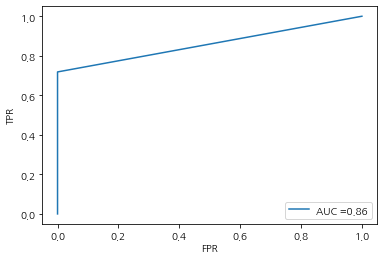

In [216]:
plt.plot(fpr,tpr,label='AUC =%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR');plt.xlabel('FPR')
plt.show()

In [217]:
model_precision.append(precision_score(df_test_y,y_pred))
model_recall.append(recall_score(df_test_y,y_pred))

model_f1_score.append(f1_score(df_test_y,y_pred))

In [218]:
df_eval = pd.DataFrame(index = model)
df_eval['TrainAccuracy'] = train_accuracy
df_eval['TestAccuracy'] = test_accuracy
df_eval['F1Score']=model_f1_score
df_eval['PrecisionScore']=model_precision
df_eval['RecallScore']=model_recall
df_eval['AUC'] = model_auc
df_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score,PrecisionScore,RecallScore,AUC
DecisionTree,0.938,0.931,0.884,0.983,0.803,0.898
RandomForest,0.901,0.907,0.836,1.000,0.718,0.859
GradientBoosting,0.933,0.935,0.836,1.000,0.718,0.859


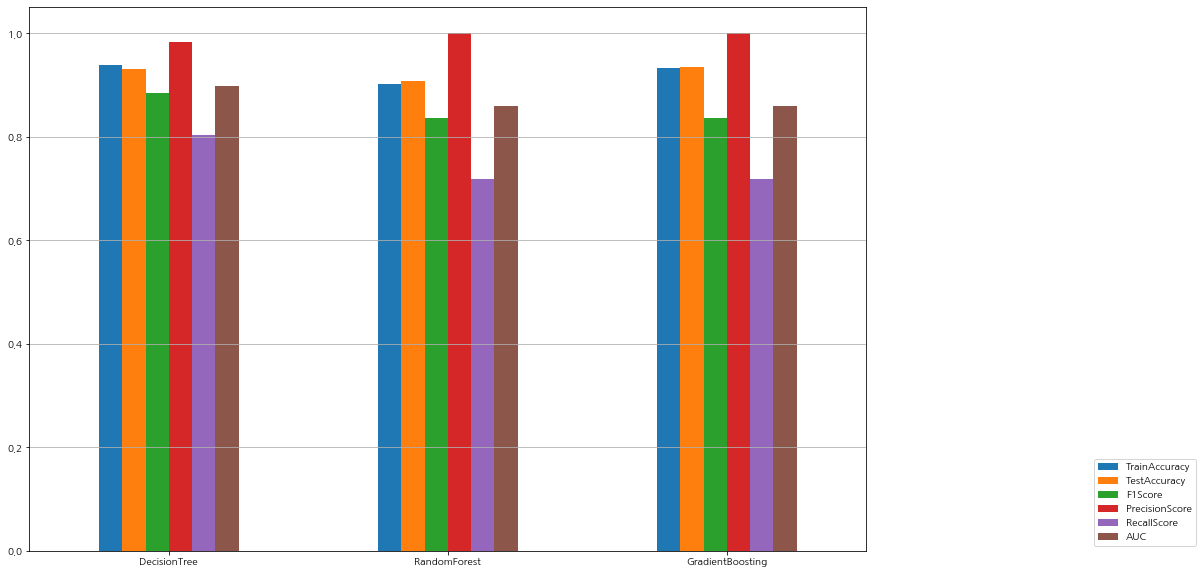

In [219]:
df_eval.plot.bar(rot=0,figsize = (15,10))
plt.legend(loc='lower right',bbox_to_anchor=(1.4,0))
plt.grid(axis = 'y')

#### 분석 : 회귀분석의 경우 다른 모델과는 매우 다른 결과를 내놓았기 때문에 제외하였다. 위의 그래프를 본결과 Decision Tree이 가장 설명력이 높다고 판단하였다.